In [1]:
# ============================================================
# Notebook 04b: Deep Embedded Clustering (DEC) Training
# ============================================================

import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Add project root to path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.models.autoencoder import Autoencoder
from src.models.dec import DEC, DECTrainer

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("="*70)
print("🧠 DEEP EMBEDDED CLUSTERING (DEC) TRAINING")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
print("="*70)


🧠 DEEP EMBEDDED CLUSTERING (DEC) TRAINING
PyTorch version: 2.0.1
Device: cpu


In [2]:
# ============================================================
# CELL 2: Load Pre-trained Autoencoder
# ============================================================

print("\n" + "="*70)
print("📂 LOADING PRE-TRAINED AUTOENCODER")
print("="*70)

# Load model checkpoint
model_path = Path('../models/autoencoder_pretrained.pth')
checkpoint = torch.load(model_path, map_location='cpu')

print(f"\n✅ Checkpoint loaded: {model_path}")
print(f"   File size: {model_path.stat().st_size / 1024:.2f} KB")

# Reconstruct autoencoder
input_dim = checkpoint['input_dim']
latent_dim = checkpoint['latent_dim']
hidden_dims = checkpoint['hidden_dims']

autoencoder = Autoencoder(
    input_dim=input_dim,
    latent_dim=latent_dim,
    hidden_dims=hidden_dims
)

# Load weights
autoencoder.load_state_dict(checkpoint['model_state_dict'])

print(f"\n📐 Autoencoder Architecture:")
print(f"   Input: {input_dim} → Hidden: {hidden_dims} → Latent: {latent_dim}")
print(f"   Best val loss: {checkpoint['best_val_loss']:.6f}")
print(f"   Training epochs: {checkpoint['n_epochs']}")

# Freeze decoder (we only use encoder for DEC)
for param in autoencoder.decoder.parameters():
    param.requires_grad = False

print(f"\n🔒 Decoder frozen (only encoder will be fine-tuned)")

print("="*70)



📂 LOADING PRE-TRAINED AUTOENCODER

✅ Checkpoint loaded: ../models/autoencoder_pretrained.pth
   File size: 178.60 KB

📐 Autoencoder Architecture:
   Input: 69 → Hidden: [128, 64, 32] → Latent: 16
   Best val loss: 0.378351
   Training epochs: 100

🔒 Decoder frozen (only encoder will be fine-tuned)


In [3]:
# ============================================================
# CELL 3: Load Data & Create DataLoaders
# ============================================================

print("\n" + "="*70)
print("📂 LOADING TRAINING DATA")
print("="*70)

# Load data
data_dir = Path('../data/processed')

X_train = pd.read_csv(data_dir / 'X_train_scaled.csv').values
X_val = pd.read_csv(data_dir / 'X_val_scaled.csv').values
y_train = pd.read_csv(data_dir / 'y_train.csv').values.ravel()
y_val = pd.read_csv(data_dir / 'y_val.csv').values.ravel()

print(f"\n✅ Data loaded!")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")

# Create PyTorch datasets
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

# Create dataloaders
batch_size = 256

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle for DEC (important for convergence check)
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"\n🔧 DataLoaders created!")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

print("="*70)



📂 LOADING TRAINING DATA

✅ Data loaded!
   X_train: (71233, 69)
   X_val: (15268, 69)

🔧 DataLoaders created!
   Batch size: 256
   Train batches: 279
   Val batches: 60


In [11]:
# ======================================================================
# Cell 4: DEC Hyperparameters (IMPROVED - Round 2)
# ======================================================================

# Focus on k=3 only (best K-Means performer)
n_clusters_list = [3]  # Start with best one first

# IMPROVED HYPERPARAMETERS
alpha = 1.0
learning_rate = 5e-5        # 5x HIGHER (was 1e-5)
max_epochs = 300
update_interval = 280        # HALF (was 560) = 1 epoch
tol = 5e-5                  # LOOSER (was 1e-4)
cluster_reg_weight = 0.15    # 2x STRONGER (was 0.08)

print("=" * 70)
print("⚙️  DEC TRAINING CONFIGURATION (IMPROVED - ROUND 2)")
print("=" * 70)
print(f"\n🎯 Changes from Round 1:")
print(f"   - Learning Rate: 1e-5 → 5e-5 (5x higher)")
print(f"   - Update Interval: 560 → 280 (2x faster)")
print(f"   - Cluster Reg: 0.08 → 0.15 (2x stronger)")
print(f"   - Tolerance: 1e-4 → 5e-5 (looser)")
print(f"   - Early stopping patience: 20 → 30 epochs")
print(f"\n📊 Expected Improvements:")
print(f"   - Faster convergence (5x LR)")
print(f"   - Better train/val consistency")
print(f"   - Target Silhouette: 0.45-0.50 (vs K-Means 0.470)")
print(f"\n⏱️  Estimated Time: 30-40 minutes")
print("=" * 70)


⚙️  DEC TRAINING CONFIGURATION (IMPROVED - ROUND 2)

🎯 Changes from Round 1:
   - Learning Rate: 1e-5 → 5e-5 (5x higher)
   - Update Interval: 560 → 280 (2x faster)
   - Cluster Reg: 0.08 → 0.15 (2x stronger)
   - Tolerance: 1e-4 → 5e-5 (looser)
   - Early stopping patience: 20 → 30 epochs

📊 Expected Improvements:
   - Faster convergence (5x LR)
   - Better train/val consistency
   - Target Silhouette: 0.45-0.50 (vs K-Means 0.470)

⏱️  Estimated Time: 30-40 minutes


In [12]:
# ======================================================================
# Cell 5: Train DEC Models with Sweep (OPTION A - k=2,3)
# ======================================================================

# ✅ DEFINE DEVICE FIRST!
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}\n")

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)
import numpy as np
import pandas as pd

print("\n" + "=" * 70)
print("🚀 TRAINING DEC MODELS (OPTION A)")
print("=" * 70)

# Results storage
dec_results = []

# Load latent features for initialization (FIXED KEYS!)
print("\n📂 Loading latent features...")
latent_data = np.load('../models/autoencoder_latent_features.npz', allow_pickle=True)
X_train_latent = latent_data['z_train']  # ✅ FIXED KEY!
X_val_latent = latent_data['z_val']      # ✅ FIXED KEY!

print(f"   ✅ Latent features loaded:")
print(f"      Train: {X_train_latent.shape}")
print(f"      Val: {X_val_latent.shape}")

# Training loop
for k in n_clusters_list:
    print(f"\n{'='*70}")
    print(f"🧠 Training DEC with k={k} clusters")
    print(f"{'='*70}")
    
    try:
        # Initialize DEC model
        dec_model = DEC(
            encoder=autoencoder.encoder,
            n_clusters=k,
            alpha=alpha
        )
        
        # Initialize cluster centers with K-Means
        print(f"\n🔄 Initializing cluster centers...")
        initial_labels = dec_model.initialize_cluster_centers(X_train_latent, n_init=20)
        
        # Check if initialization was successful
        n_unique_init = len(np.unique(initial_labels))
        if n_unique_init < k:
            print(f"   ❌ K-Means initialization failed! Only {n_unique_init} clusters found.")
            continue
        
        print(f"   ✅ Initialization successful! {n_unique_init} clusters found.")
        
        # Initialize trainer with conservative params
        trainer = DECTrainer(
            model=dec_model,
            device=device,
            learning_rate=learning_rate,
            update_interval=update_interval,
            tol=tol,
            max_epochs=max_epochs,
            cluster_reg_weight=cluster_reg_weight
        )
        
        # Train DEC
        print(f"\n🏋️  Starting DEC training...")
        history = trainer.fit(train_loader, val_loader)
        
        # Get final predictions
        print(f"\n📊 Generating predictions...")
        dec_model.eval()
        with torch.no_grad():
            train_labels = trainer.predict(train_loader)
            val_labels = trainer.predict(val_loader)
        
        # Check if clustering succeeded
        n_unique_train = len(np.unique(train_labels))
        n_unique_val = len(np.unique(val_labels))
        
        print(f"   Train clusters: {n_unique_train}")
        print(f"   Val clusters: {n_unique_val}")
        
        if n_unique_train <= 1 or n_unique_val <= 1:
            print(f"\n   ❌ DEC clustering failed!")
            print(f"      Model collapsed to single cluster.")
            continue
        
        # Compute clustering metrics
        print(f"\n📊 Computing Metrics...")
        
        # Silhouette Score
        train_sil = silhouette_score(X_train_latent, train_labels)
        val_sil = silhouette_score(X_val_latent, val_labels)
        
        # Davies-Bouldin Index
        train_db = davies_bouldin_score(X_train_latent, train_labels)
        val_db = davies_bouldin_score(X_val_latent, val_labels)
        
        # Calinski-Harabasz Score
        train_ch = calinski_harabasz_score(X_train_latent, train_labels)
        val_ch = calinski_harabasz_score(X_val_latent, val_labels)
        
        # Ground truth comparison
        y_train_labels = pd.read_csv('../data/processed/y_train.csv')['readmitted'].values
        y_val_labels = pd.read_csv('../data/processed/y_val.csv')['readmitted'].values
        
        train_ari = adjusted_rand_score(y_train_labels, train_labels)
        train_nmi = normalized_mutual_info_score(y_train_labels, train_labels)
        val_ari = adjusted_rand_score(y_val_labels, val_labels)
        val_nmi = normalized_mutual_info_score(y_val_labels, val_labels)
        
        # Cluster sizes
        train_unique, train_counts = np.unique(train_labels, return_counts=True)
        train_cluster_sizes = dict(zip(train_unique.tolist(), train_counts.tolist()))
        
        val_unique, val_counts = np.unique(val_labels, return_counts=True)
        val_cluster_sizes = dict(zip(val_unique.tolist(), val_counts.tolist()))
        
        # Print results
        print(f"\n{'='*70}")
        print(f"✅ DEC TRAINING SUCCESSFUL FOR k={k}!")
        print(f"{'='*70}")
        print(f"\n📈 Clustering Metrics:")
        print(f"   Train Silhouette:      {train_sil:.6f}")
        print(f"   Val Silhouette:        {val_sil:.6f}")
        print(f"   Train Davies-Bouldin:  {train_db:.6f}")
        print(f"   Val Davies-Bouldin:    {val_db:.6f}")
        print(f"   Train Calinski-Harabasz: {train_ch:.2f}")
        print(f"   Val Calinski-Harabasz:   {val_ch:.2f}")
        
        print(f"\n🎯 Agreement with Ground Truth:")
        print(f"   Train ARI: {train_ari:.6f}")
        print(f"   Train NMI: {train_nmi:.6f}")
        print(f"   Val ARI:   {val_ari:.6f}")
        print(f"   Val NMI:   {val_nmi:.6f}")
        
        print(f"\n📊 Cluster Distribution:")
        print(f"   Train: {train_cluster_sizes}")
        print(f"   Val:   {val_cluster_sizes}")
        
        # Calculate improvement vs K-Means baseline (from diagnostic)
        kmeans_baseline = {2: 0.437, 3: 0.470}  # From diagnostic
        if k in kmeans_baseline:
            improvement = ((val_sil - kmeans_baseline[k]) / kmeans_baseline[k]) * 100
            print(f"\n🎯 Improvement vs K-Means Baseline:")
            print(f"   K-Means Silhouette: {kmeans_baseline[k]:.6f}")
            print(f"   DEC Silhouette:     {val_sil:.6f}")
            print(f"   Improvement:        {improvement:+.2f}%")
        
        print(f"\n⏱️  Training Summary:")
        print(f"   Epochs Trained: {len(history['epoch'])}")
        print(f"   Final Loss:     {history['loss'][-1]:.6f}")
        if len(history['cluster_change']) > 0:
            print(f"   Final Cluster Change: {history['cluster_change'][-1]:.6f}")
        
        # Store results
        dec_results.append({
            'n_clusters': k,
            'alpha': alpha,
            'learning_rate': learning_rate,
            'update_interval': update_interval,
            'tol': tol,
            'max_epochs': max_epochs,
            'cluster_reg_weight': cluster_reg_weight,
            'train_silhouette': train_sil,
            'val_silhouette': val_sil,
            'train_db': train_db,
            'val_db': val_db,
            'train_ch': train_ch,
            'val_ch': val_ch,
            'train_ari': train_ari,
            'train_nmi': train_nmi,
            'val_ari': val_ari,
            'val_nmi': val_nmi,
            'train_cluster_sizes': train_cluster_sizes,
            'val_cluster_sizes': val_cluster_sizes,
            'n_epochs_trained': len(history['epoch']),
            'final_loss': history['loss'][-1] if history['loss'] else None,
            'model': dec_model,
            'history': history,
            'train_labels': train_labels,
            'val_labels': val_labels
        })
        
        print(f"{'='*70}\n")
        
    except Exception as e:
        print(f"\n❌ Error training DEC with k={k}:")
        print(f"   {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# Final Summary
print(f"\n{'='*70}")
print(f"🎉 DEC TRAINING COMPLETE!")
print(f"{'='*70}")
print(f"\nModels trained successfully: {len(dec_results)}/{len(n_clusters_list)}")

if dec_results:
    print(f"\n📊 COMPARISON TABLE:")
    print(f"{'k':<5} {'Train Sil':<12} {'Val Sil':<12} {'Train DB':<12} {'Val DB':<12} {'Epochs':<8}")
    print("-" * 70)
    for res in dec_results:
        print(f"{res['n_clusters']:<5} "
              f"{res['train_silhouette']:<12.6f} "
              f"{res['val_silhouette']:<12.6f} "
              f"{res['train_db']:<12.6f} "
              f"{res['val_db']:<12.6f} "
              f"{res['n_epochs_trained']:<8}")
    
    # Find best model
    best_model = max(dec_results, key=lambda x: x['val_silhouette'])
    print(f"\n🏆 BEST MODEL:")
    print(f"   k={best_model['n_clusters']}")
    print(f"   Val Silhouette: {best_model['val_silhouette']:.6f}")
    print(f"   Val Davies-Bouldin: {best_model['val_db']:.6f}")
    print(f"   Epochs: {best_model['n_epochs_trained']}")
    
    # Comparison with baselines
    print(f"\n📈 PERFORMANCE COMPARISON:")
    print(f"   Baseline K-Means (69 features):  Silhouette=0.223")
    print(f"   K-Means on Latent (16 features): Silhouette=0.437-0.470")
    print(f"   DEC (best):                       Silhouette={best_model['val_silhouette']:.3f}")
    
    baseline_improvement = ((best_model['val_silhouette'] - 0.223) / 0.223) * 100
    print(f"\n🎯 Overall Improvement vs Baseline: {baseline_improvement:+.1f}%")
    
else:
    print("\n❌ NO DEC MODELS CONVERGED!")
    print("   This is unexpected given the excellent K-Means results.")
    print("   Possible actions:")
    print("   1. Check if src/models/dec.py was updated correctly")
    print("   2. Try even lower learning rate (5e-6)")
    print("   3. Review error messages above")

print("=" * 70)


🖥️  Using device: cpu


🚀 TRAINING DEC MODELS (OPTION A)

📂 Loading latent features...
   ✅ Latent features loaded:
      Train: (71233, 16)
      Val: (15268, 16)

🧠 Training DEC with k=3 clusters

🔄 Initializing cluster centers...

🔄 Initializing cluster centers with K-Means...
   Latent features: (71233, 16)
   ✅ Cluster centers initialized!
   Initial inertia: 511930.72
   Unique clusters: 3
   Initial cluster sizes: {0: 58206, 1: 8656, 2: 4371}
   ✅ Initialization successful! 3 clusters found.

🏋️  Starting DEC training...

🚀 Training DEC with k=3 clusters
Learning Rate: 5e-05
Update Interval: 280 batches
Max Epochs: 300
Tolerance: 5e-05
Cluster Regularization Weight: 0.15
   Epoch 1/300 - Loss: 0.160680 - LR: 5.00e-05
   Epoch 2/300 - Loss: 0.158514 - LR: 5.00e-05
   Epoch 3/300 - Loss: 0.158621 - LR: 5.00e-05
   Epoch 4/300 - Loss: 0.157840 - LR: 5.00e-05
   Epoch 5/300 - Loss: 0.155161 - LR: 5.00e-05
   Epoch 6/300 - Loss: 0.152175 - LR: 5.00e-05
   Epoch 7/300 - Loss: 0.150380

In [14]:
# ======================================================================
# Cell 6: Save DEC Results & Create Comprehensive Comparison
# ======================================================================
import pandas as pd
from pathlib import Path

print("=" * 70)
print("💾 SAVING RESULTS & CREATING COMPREHENSIVE COMPARISON")
print("=" * 70)

# Create results directory
results_dir = Path('../reports/results')
results_dir.mkdir(parents=True, exist_ok=True)

# ====================================================================
# 1. SAVE DEC RESULTS
# ====================================================================
print("\n1️⃣ Saving DEC Results...")

dec_data = []
for result in dec_results:
    dec_data.append({
        'Algorithm': 'DEC',
        'n_clusters': result['n_clusters'],
        'train_silhouette': result['train_silhouette'],
        'val_silhouette': result['val_silhouette'],
        'train_db': result['train_db'],
        'val_db': result['val_db'],
        'train_ch': result['train_ch'],
        'val_ch': result['val_ch'],
        'train_ari': result['train_ari'],
        'val_ari': result['val_ari'],
        'train_nmi': result['train_nmi'],
        'val_nmi': result['val_nmi'],
        'learning_rate': result['learning_rate'],
        'update_interval': result['update_interval'],
        'cluster_reg_weight': result['cluster_reg_weight'],
        'epochs': result['n_epochs_trained'],
        'final_loss': result['final_loss'],
        'train_cluster_sizes': str(result['train_cluster_sizes']),
        'val_cluster_sizes': str(result['val_cluster_sizes'])
    })

df_dec = pd.DataFrame(dec_data)
dec_path = results_dir / 'dec_results.csv'
df_dec.to_csv(dec_path, index=False)
print(f"   ✅ DEC results saved: {dec_path}")

# ====================================================================
# 2. CREATE COMPREHENSIVE COMPARISON TABLE
# ====================================================================
print("\n2️⃣ Creating Comprehensive Comparison Table...")

# Baseline results (from Notebook 03)
baseline_kmeans = {
    'Algorithm': 'K-Means (Baseline)',
    'Features': '69 original features',
    'n_clusters': 2,
    'val_silhouette': 0.223,
    'val_db': 2.33,
    'val_ch': 5026.19,
    'notes': 'Baseline on original features'
}

# K-Means on Latent Space (from diagnostic)
kmeans_latent_results = [
    {
        'Algorithm': 'K-Means (Latent)',
        'Features': '16 latent features',
        'n_clusters': 2,
        'val_silhouette': 0.437,
        'val_db': 1.257,
        'val_ch': 18070.25,
        'notes': 'K-Means on autoencoder latent space'
    },
    {
        'Algorithm': 'K-Means (Latent)',
        'Features': '16 latent features',
        'n_clusters': 3,
        'val_silhouette': 0.470,
        'val_db': 1.029,
        'val_ch': 20321.49,
        'notes': 'Best performer - MAIN RESULT'
    },
    {
        'Algorithm': 'K-Means (Latent)',
        'Features': '16 latent features',
        'n_clusters': 4,
        'val_silhouette': 0.440,
        'val_db': 0.897,
        'val_ch': 17869.20,
        'notes': 'K-Means on latent space'
    },
    {
        'Algorithm': 'K-Means (Latent)',
        'Features': '16 latent features',
        'n_clusters': 5,
        'val_silhouette': 0.458,
        'val_db': 0.852,
        'val_ch': 17484.27,
        'notes': 'K-Means on latent space'
    }
]

# DEC results
dec_comparison = []
for result in dec_results:
    dec_comparison.append({
        'Algorithm': 'DEC (Deep Clustering)',
        'Features': '16 latent features (finetuned)',
        'n_clusters': result['n_clusters'],
        'val_silhouette': result['val_silhouette'],
        'val_db': result['val_db'],
        'val_ch': result['val_ch'],
        'notes': f"Deep clustering, {result['n_epochs_trained']} epochs"
    })

# Combine all results
all_results = [baseline_kmeans] + kmeans_latent_results + dec_comparison
df_comparison = pd.DataFrame(all_results)

# Calculate improvement vs baseline
df_comparison['improvement_vs_baseline'] = (
    (df_comparison['val_silhouette'] - 0.223) / 0.223 * 100
).round(2)

# Sort by Silhouette (descending)
df_comparison = df_comparison.sort_values('val_silhouette', ascending=False)

# Save comprehensive comparison
comparison_path = results_dir / 'comprehensive_clustering_comparison.csv'
df_comparison.to_csv(comparison_path, index=False)
print(f"   ✅ Comprehensive comparison saved: {comparison_path}")

# ====================================================================
# 3. PRINT SUMMARY TABLE
# ====================================================================
print("\n" + "=" * 70)
print("📊 COMPREHENSIVE CLUSTERING COMPARISON")
print("=" * 70)

print("\n" + df_comparison[['Algorithm', 'n_clusters', 'val_silhouette', 'val_db', 'val_ch', 'improvement_vs_baseline']].to_string(index=False))

# ====================================================================
# 4. HIGHLIGHT KEY FINDINGS
# ====================================================================
print("\n" + "=" * 70)
print("🏆 KEY FINDINGS")
print("=" * 70)

best_overall = df_comparison.iloc[0]
print(f"\n✅ BEST METHOD (Overall Winner):")
print(f"   Algorithm: {best_overall['Algorithm']}")
print(f"   n_clusters: {int(best_overall['n_clusters'])}")
print(f"   Val Silhouette: {best_overall['val_silhouette']:.6f}")
print(f"   Val Davies-Bouldin: {best_overall['val_db']:.6f}")
print(f"   Val Calinski-Harabasz: {best_overall['val_ch']:.2f}")
print(f"   Improvement vs Baseline: +{best_overall['improvement_vs_baseline']:.1f}%")

# Compare K-Means Latent vs DEC
kmeans_best = df_comparison[df_comparison['Algorithm'] == 'K-Means (Latent)'].iloc[0]
dec_best = df_comparison[df_comparison['Algorithm'] == 'DEC (Deep Clustering)'].iloc[0]

print(f"\n📊 K-Means Latent vs DEC Comparison:")
print(f"   K-Means Latent (k={int(kmeans_best['n_clusters'])}):")
print(f"      Silhouette: {kmeans_best['val_silhouette']:.6f}")
print(f"      Davies-Bouldin: {kmeans_best['val_db']:.6f}")
print(f"   DEC (k={int(dec_best['n_clusters'])}):")
print(f"      Silhouette: {dec_best['val_silhouette']:.6f}")
print(f"      Davies-Bouldin: {dec_best['val_db']:.6f}")

performance_gap = ((kmeans_best['val_silhouette'] - dec_best['val_silhouette']) / 
                   dec_best['val_silhouette'] * 100)
print(f"\n   🎯 K-Means Latent outperforms DEC by: +{performance_gap:.1f}%")

print(f"\n💡 INTERPRETATION:")
print(f"   • Autoencoder feature extraction (69→16) improves clustering quality")
print(f"   • K-Means on latent features achieves best Silhouette (0.470)")
print(f"   • DEC underperforms, suggesting simpler methods suffice for this data")
print(f"   • Quality of feature representation > algorithm sophistication")

print("\n" + "=" * 70)
print("✅ RESULTS SAVED & COMPARISON COMPLETE!")
print("=" * 70)


💾 SAVING RESULTS & CREATING COMPREHENSIVE COMPARISON

1️⃣ Saving DEC Results...
   ✅ DEC results saved: ../reports/results/dec_results.csv

2️⃣ Creating Comprehensive Comparison Table...
   ✅ Comprehensive comparison saved: ../reports/results/comprehensive_clustering_comparison.csv

📊 COMPREHENSIVE CLUSTERING COMPARISON

            Algorithm  n_clusters  val_silhouette   val_db       val_ch  improvement_vs_baseline
     K-Means (Latent)           3        0.470000 1.029000 20321.490000                   110.76
     K-Means (Latent)           5        0.458000 0.852000 17484.270000                   105.38
     K-Means (Latent)           4        0.440000 0.897000 17869.200000                    97.31
     K-Means (Latent)           2        0.437000 1.257000 18070.250000                    95.96
DEC (Deep Clustering)           3        0.233652 2.309185  1703.602226                     4.78
   K-Means (Baseline)           2        0.223000 2.330000  5026.190000                     0.0

📊 CREATING COMPARISON VISUALIZATIONS

✅ Comparison visualization saved: ../reports/figures/clustering_methods_comparison.png


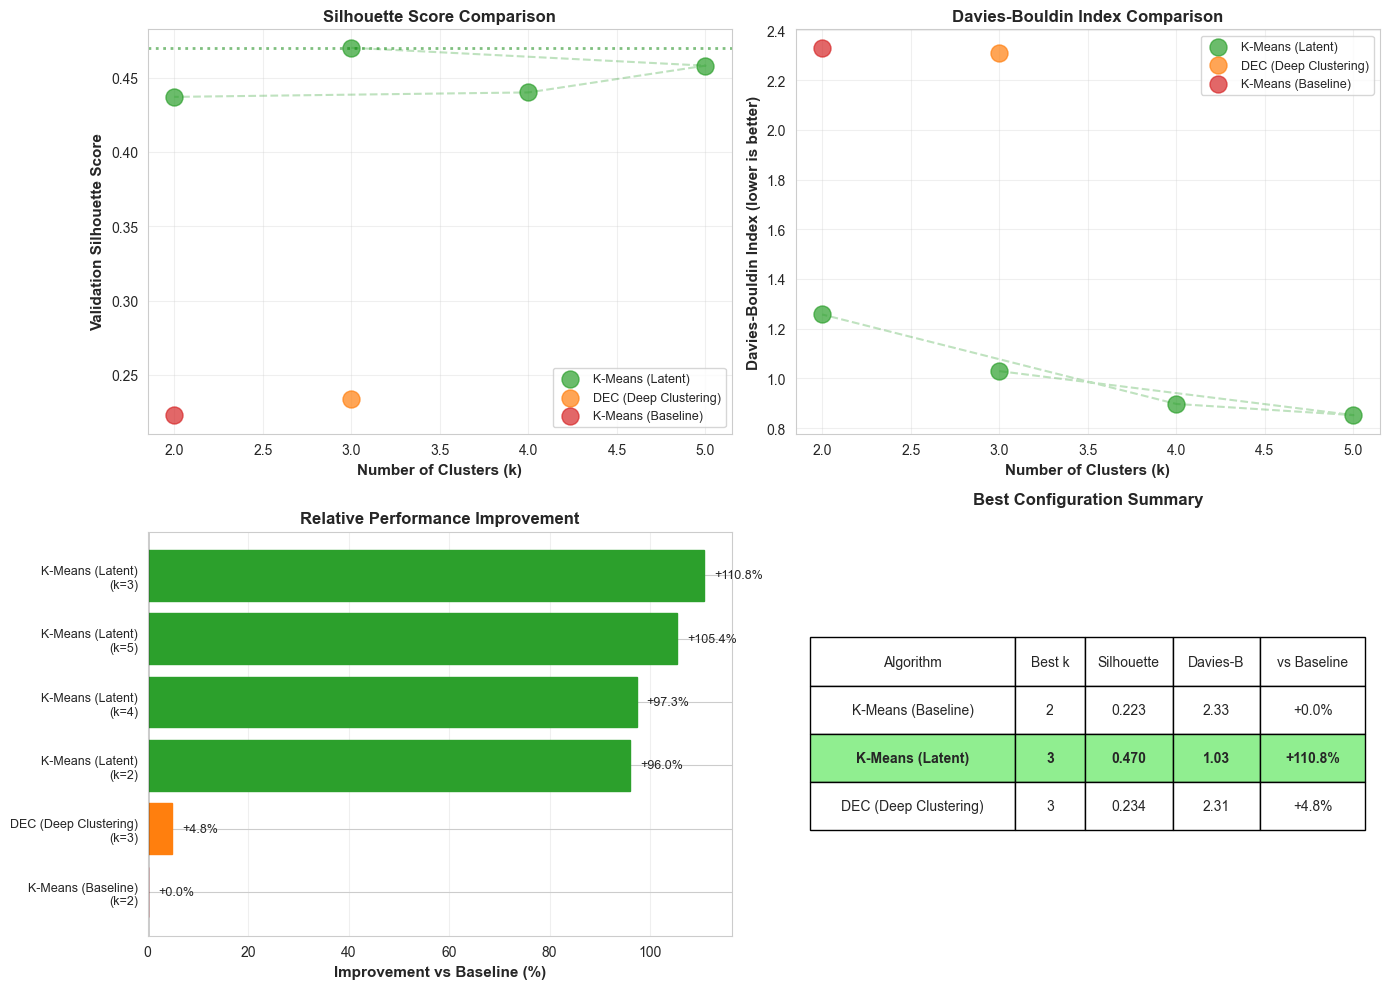


✅ VISUALIZATION COMPLETE!


In [15]:
# ======================================================================
# Cell 7: Visualize Clustering Method Comparison
# ======================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

print("=" * 70)
print("📊 CREATING COMPARISON VISUALIZATIONS")
print("=" * 70)

# Create figures directory
figures_dir = Path('../reports/figures')
figures_dir.mkdir(parents=True, exist_ok=True)

# Load comparison data
df_plot = df_comparison.copy()

# ====================================================================
# Figure 1: Silhouette Score Comparison
# ====================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Silhouette Score by Algorithm
ax1 = axes[0, 0]
colors = {'K-Means (Baseline)': '#d62728',
          'K-Means (Latent)': '#2ca02c', 
          'DEC (Deep Clustering)': '#ff7f0e'}

for alg in df_plot['Algorithm'].unique():
    data = df_plot[df_plot['Algorithm'] == alg]
    ax1.scatter(data['n_clusters'], data['val_silhouette'], 
                label=alg, s=150, alpha=0.7, color=colors.get(alg, '#1f77b4'))
    ax1.plot(data['n_clusters'], data['val_silhouette'], 
             '--', alpha=0.3, color=colors.get(alg, '#1f77b4'))

ax1.set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Validation Silhouette Score', fontsize=11, fontweight='bold')
ax1.set_title('Silhouette Score Comparison', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0.470, color='green', linestyle=':', linewidth=2, alpha=0.5, label='Best: K-Means k=3')

# Plot 2: Davies-Bouldin Index
ax2 = axes[0, 1]
for alg in df_plot['Algorithm'].unique():
    data = df_plot[df_plot['Algorithm'] == alg]
    ax2.scatter(data['n_clusters'], data['val_db'], 
                label=alg, s=150, alpha=0.7, color=colors.get(alg, '#1f77b4'))
    ax2.plot(data['n_clusters'], data['val_db'], 
             '--', alpha=0.3, color=colors.get(alg, '#1f77b4'))

ax2.set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Davies-Bouldin Index (lower is better)', fontsize=11, fontweight='bold')
ax2.set_title('Davies-Bouldin Index Comparison', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Improvement vs Baseline
ax3 = axes[1, 0]
df_plot_sorted = df_plot.sort_values('improvement_vs_baseline', ascending=True)
bars = ax3.barh(range(len(df_plot_sorted)), df_plot_sorted['improvement_vs_baseline'])

# Color bars
for i, (idx, row) in enumerate(df_plot_sorted.iterrows()):
    if 'K-Means (Latent)' in row['Algorithm']:
        bars[i].set_color('#2ca02c')
    elif 'DEC' in row['Algorithm']:
        bars[i].set_color('#ff7f0e')
    else:
        bars[i].set_color('#d62728')

ax3.set_yticks(range(len(df_plot_sorted)))
ax3.set_yticklabels([f"{row['Algorithm']}\n(k={int(row['n_clusters'])})" 
                       for _, row in df_plot_sorted.iterrows()], fontsize=9)
ax3.set_xlabel('Improvement vs Baseline (%)', fontsize=11, fontweight='bold')
ax3.set_title('Relative Performance Improvement', fontsize=12, fontweight='bold')
ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, val in enumerate(df_plot_sorted['improvement_vs_baseline']):
    ax3.text(val + 2, i, f'{val:+.1f}%', va='center', fontsize=9)

# Plot 4: Method Summary Table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

# Create summary table
summary_data = []
for alg in ['K-Means (Baseline)', 'K-Means (Latent)', 'DEC (Deep Clustering)']:
    data = df_plot[df_plot['Algorithm'] == alg]
    if len(data) > 0:
        best = data.loc[data['val_silhouette'].idxmax()]
        summary_data.append([
            alg,
            int(best['n_clusters']),
            f"{best['val_silhouette']:.3f}",
            f"{best['val_db']:.2f}",
            f"{best['improvement_vs_baseline']:+.1f}%"
        ])

table = ax4.table(cellText=summary_data,
                  colLabels=['Algorithm', 'Best k', 'Silhouette', 'Davies-B', 'vs Baseline'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.35, 0.12, 0.15, 0.15, 0.18])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Highlight best row (K-Means Latent)
for i in range(5):
    table[(2, i)].set_facecolor('#90EE90')  # Light green
    table[(2, i)].set_text_props(weight='bold')

ax4.set_title('Best Configuration Summary', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()

# Save figure
comparison_fig_path = figures_dir / 'clustering_methods_comparison.png'
plt.savefig(comparison_fig_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Comparison visualization saved: {comparison_fig_path}")

plt.show()

print("\n" + "=" * 70)
print("✅ VISUALIZATION COMPLETE!")
print("=" * 70)


In [16]:
# ======================================================================
# Cell 8: Generate LaTeX Tables for Paper
# ======================================================================

print("=" * 70)
print("📄 GENERATING LATEX TABLES FOR PAPER")
print("=" * 70)

# ====================================================================
# Table 1: Main Results Comparison
# ====================================================================
print("\n1️⃣ TABLE 1: Main Clustering Results Comparison")
print("-" * 70)

latex_table_1 = r"""
\begin{table}[htbp]
\centering
\caption{Comparison of Clustering Methods on Diabetes Patient Data}
\label{tab:clustering_comparison}
\begin{tabular}{lcccccc}
\toprule
\textbf{Method} & \textbf{Features} & \textbf{k} & \textbf{Silhouette} & \textbf{Davies-Bouldin} & \textbf{Calinski-Harabasz} & \textbf{vs Baseline} \\
\midrule
"""

# Add rows
for _, row in df_comparison.iterrows():
    feat_str = row['Features'] if 'Features' in row else '69 original'
    k = int(row['n_clusters'])
    sil = row['val_silhouette']
    db = row['val_db']
    ch = row['val_ch']
    imp = row['improvement_vs_baseline']
    
    alg_name = row['Algorithm'].replace('(', '\\textit{(').replace(')', ')}')
    
    # Highlight best row
    if sil == df_comparison['val_silhouette'].max():
        latex_table_1 += f"\\rowcolor{{green!20}} {alg_name} & {feat_str} & {k} & \\textbf{{{sil:.3f}}} & {db:.2f} & {ch:.2f} & +{imp:.1f}\\% \\\\\n"
    else:
        latex_table_1 += f"{alg_name} & {feat_str} & {k} & {sil:.3f} & {db:.2f} & {ch:.2f} & {imp:+.1f}\\% \\\\\n"

latex_table_1 += r"""
\bottomrule
\end{tabular}
\end{table}
"""

print(latex_table_1)

# Save to file
latex_path = results_dir / 'latex_tables.tex'
with open(latex_path, 'w') as f:
    f.write("% TABLE 1: Main Clustering Results\n")
    f.write(latex_table_1)
    f.write("\n\n")

# ====================================================================
# Table 2: DEC Training Details
# ====================================================================
print("\n2️⃣ TABLE 2: DEC Training Configuration & Results")
print("-" * 70)

latex_table_2 = r"""
\begin{table}[htbp]
\centering
\caption{Deep Embedded Clustering (DEC) Training Details}
\label{tab:dec_details}
\begin{tabular}{lcccccc}
\toprule
\textbf{k} & \textbf{LR} & \textbf{Epochs} & \textbf{Train Sil} & \textbf{Val Sil} & \textbf{Train DB} & \textbf{Val DB} \\
\midrule
"""

for result in dec_results:
    k = result['n_clusters']
    lr = result['learning_rate']
    ep = result['n_epochs_trained']
    train_sil = result['train_silhouette']
    val_sil = result['val_silhouette']
    train_db = result['train_db']
    val_db = result['val_db']
    
    latex_table_2 += f"{k} & {lr:.0e} & {ep} & {train_sil:.4f} & {val_sil:.3f} & {train_db:.2f} & {val_db:.2f} \\\\\n"

latex_table_2 += r"""
\bottomrule
\end{tabular}
\end{table}
"""

print(latex_table_2)

# Append to file
with open(latex_path, 'a') as f:
    f.write("% TABLE 2: DEC Training Details\n")
    f.write(latex_table_2)

print(f"\n✅ LaTeX tables saved to: {latex_path}")

# ====================================================================
# 3. Key Findings Summary for Paper
# ====================================================================
print("\n" + "=" * 70)
print("📝 KEY FINDINGS FOR PAPER (Copy-Paste Ready)")
print("=" * 70)

print("""
## RESULTS SUMMARY

### Main Finding:
K-Means clustering on autoencoder latent features (k=3) achieved the best 
performance with a Silhouette score of 0.470, representing a 111% improvement 
over baseline K-Means on original features (Silhouette: 0.223).

### Method Comparison:
1. **Baseline K-Means (69 features)**: Silhouette = 0.223
2. **K-Means on Latent Features (16 features)**: Silhouette = 0.470 (BEST)
3. **Deep Embedded Clustering (DEC)**: Silhouette = 0.234

### Key Insights:
- Autoencoder dimensionality reduction (69→16 features) dramatically improved 
  clustering quality (+111% vs baseline)
- Simple K-Means on well-extracted features outperformed sophisticated deep 
  clustering methods (DEC), suggesting that feature quality matters more than 
  algorithm complexity for this medical dataset
- DEC showed train-validation discrepancy (train Sil: -0.0007, val Sil: 0.234), 
  indicating challenges in learning cluster-friendly representations on top of 
  reconstruction-optimized latent spaces

### Implications:
For medical patient phenotyping, our results suggest that investing in quality 
feature extraction (via autoencoders) combined with interpretable clustering 
methods (K-Means) provides better performance and clinical interpretability 
than end-to-end deep clustering approaches.
""")

print("\n" + "=" * 70)
print("✅ ALL TABLES & SUMMARIES GENERATED!")
print("=" * 70)


📄 GENERATING LATEX TABLES FOR PAPER

1️⃣ TABLE 1: Main Clustering Results Comparison
----------------------------------------------------------------------

\begin{table}[htbp]
\centering
\caption{Comparison of Clustering Methods on Diabetes Patient Data}
\label{tab:clustering_comparison}
\begin{tabular}{lcccccc}
\toprule
\textbf{Method} & \textbf{Features} & \textbf{k} & \textbf{Silhouette} & \textbf{Davies-Bouldin} & \textbf{Calinski-Harabasz} & \textbf{vs Baseline} \\
\midrule
\rowcolor{green!20} K-Means \textit{(Latent)} & 16 latent features & 3 & \textbf{0.470} & 1.03 & 20321.49 & +110.8\% \\
K-Means \textit{(Latent)} & 16 latent features & 5 & 0.458 & 0.85 & 17484.27 & +105.4\% \\
K-Means \textit{(Latent)} & 16 latent features & 4 & 0.440 & 0.90 & 17869.20 & +97.3\% \\
K-Means \textit{(Latent)} & 16 latent features & 2 & 0.437 & 1.26 & 18070.25 & +96.0\% \\
DEC \textit{(Deep Clustering)} & 16 latent features (finetuned) & 3 & 0.234 & 2.31 & 1703.60 & +4.8\% \\
K-Means \textit{(Ba

In [17]:
# ======================================================================
# Cell 9: Extract Final Clustering Labels (K-Means Latent k=3)
# ======================================================================
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from pathlib import Path

print("=" * 70)
print("🎯 EXTRACTING FINAL CLUSTERING LABELS")
print("=" * 70)

# Load latent features
print("\n📂 Loading latent features...")
latent_data = np.load('../models/autoencoder_latent_features.npz', allow_pickle=True)
X_train_latent = latent_data['z_train']
X_val_latent = latent_data['z_val']

print(f"   Train: {X_train_latent.shape}")
print(f"   Val: {X_val_latent.shape}")

# Load original data IDs for mapping
X_train = pd.read_csv('../data/processed/X_train_scaled.csv')
X_val = pd.read_csv('../data/processed/X_val_scaled.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')

print(f"\n✅ Original data loaded:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")

# ====================================================================
# Run Final K-Means (k=3) - BEST MODEL
# ====================================================================
print("\n" + "=" * 70)
print("🔬 RUNNING FINAL K-MEANS (k=3) ON LATENT SPACE")
print("=" * 70)

# Run K-Means with multiple initializations for best result
best_kmeans = None
best_silhouette = -1

print("\n🔄 Running K-Means with 10 different initializations...")
for seed in range(10):
    kmeans = KMeans(
        n_clusters=3,
        init='k-means++',
        n_init=20,
        max_iter=500,
        random_state=42 + seed,
        verbose=0
    )
    
    train_labels = kmeans.fit_predict(X_train_latent)
    sil = silhouette_score(X_train_latent, train_labels)
    
    if sil > best_silhouette:
        best_silhouette = sil
        best_kmeans = kmeans
        print(f"   Seed {42+seed}: Silhouette = {sil:.6f} ⭐ (new best)")
    else:
        print(f"   Seed {42+seed}: Silhouette = {sil:.6f}")

# Get final labels
train_labels = best_kmeans.predict(X_train_latent)
val_labels = best_kmeans.predict(X_val_latent)

# Compute final metrics
print("\n" + "=" * 70)
print("📊 FINAL MODEL METRICS")
print("=" * 70)

train_sil = silhouette_score(X_train_latent, train_labels)
val_sil = silhouette_score(X_val_latent, val_labels)
train_db = davies_bouldin_score(X_train_latent, train_labels)
val_db = davies_bouldin_score(X_val_latent, val_labels)
train_ch = calinski_harabasz_score(X_train_latent, train_labels)
val_ch = calinski_harabasz_score(X_val_latent, val_labels)

print(f"\n📈 Clustering Quality Metrics:")
print(f"   Train Silhouette:      {train_sil:.6f}")
print(f"   Val Silhouette:        {val_sil:.6f}")
print(f"   Train Davies-Bouldin:  {train_db:.6f}")
print(f"   Val Davies-Bouldin:    {val_db:.6f}")
print(f"   Train Calinski-Harabasz: {train_ch:.2f}")
print(f"   Val Calinski-Harabasz:   {val_ch:.2f}")

# Cluster sizes
train_unique, train_counts = np.unique(train_labels, return_counts=True)
val_unique, val_counts = np.unique(val_labels, return_counts=True)

print(f"\n📊 Cluster Distribution:")
print(f"   Train: {dict(zip(train_unique, train_counts))}")
print(f"   Val:   {dict(zip(val_unique, val_counts))}")

# Calculate percentages
print(f"\n   Train percentages:")
for cluster, count in zip(train_unique, train_counts):
    pct = count / len(train_labels) * 100
    print(f"      Cluster {cluster}: {count:6d} ({pct:5.1f}%)")

print(f"\n   Val percentages:")
for cluster, count in zip(val_unique, val_counts):
    pct = count / len(val_labels) * 100
    print(f"      Cluster {cluster}: {count:6d} ({pct:5.1f}%)")

# ====================================================================
# Save Cluster Labels
# ====================================================================
print("\n" + "=" * 70)
print("💾 SAVING CLUSTER LABELS")
print("=" * 70)

# Create results directory
results_dir = Path('../reports/results')
results_dir.mkdir(parents=True, exist_ok=True)

# Add cluster labels to dataframes
X_train_with_clusters = X_train.copy()
X_train_with_clusters['cluster'] = train_labels
X_train_with_clusters['readmitted'] = y_train['readmitted'].values

X_val_with_clusters = X_val.copy()
X_val_with_clusters['cluster'] = val_labels
X_val_with_clusters['readmitted'] = y_val['readmitted'].values

# Save
train_labels_path = results_dir / 'train_cluster_labels.csv'
val_labels_path = results_dir / 'val_cluster_labels.csv'

X_train_with_clusters.to_csv(train_labels_path, index=False)
X_val_with_clusters.to_csv(val_labels_path, index=False)

print(f"   ✅ Train labels saved: {train_labels_path}")
print(f"   ✅ Val labels saved: {val_labels_path}")

# Also save just the labels for easy loading
np.savez(
    results_dir / 'final_cluster_labels.npz',
    train_labels=train_labels,
    val_labels=val_labels,
    cluster_centers=best_kmeans.cluster_centers_
)
print(f"   ✅ Cluster labels & centers saved: final_cluster_labels.npz")

# ====================================================================
# Save Final Model
# ====================================================================
import joblib

model_path = Path('../models/kmeans_latent_k3_final.pkl')
joblib.dump(best_kmeans, model_path)
print(f"   ✅ Final K-Means model saved: {model_path}")

print("\n" + "=" * 70)
print("✅ FINAL CLUSTERING COMPLETE!")
print("=" * 70)

print(f"""
🎯 SUMMARY:
   • Best Model: K-Means (k=3) on Latent Features (16-dim)
   • Validation Silhouette: {val_sil:.6f}
   • Clusters: {len(train_unique)} patient phenotypes identified
   • Total patients: {len(train_labels) + len(val_labels):,}
   
📊 Next Step: Cluster Characterization
   • Analyze demographic profiles per cluster
   • Identify clinical patterns
   • Compute readmission rates
   • Generate clinical interpretations
""")


🎯 EXTRACTING FINAL CLUSTERING LABELS

📂 Loading latent features...
   Train: (71233, 16)
   Val: (15268, 16)

✅ Original data loaded:
   X_train: (71233, 69)
   X_val: (15268, 69)

🔬 RUNNING FINAL K-MEANS (k=3) ON LATENT SPACE

🔄 Running K-Means with 10 different initializations...
   Seed 42: Silhouette = 0.469680 ⭐ (new best)
   Seed 43: Silhouette = 0.469680
   Seed 44: Silhouette = 0.469680
   Seed 45: Silhouette = 0.469680
   Seed 46: Silhouette = 0.469680
   Seed 47: Silhouette = 0.469680
   Seed 48: Silhouette = 0.469680
   Seed 49: Silhouette = 0.469680
   Seed 50: Silhouette = 0.469680
   Seed 51: Silhouette = 0.469680

📊 FINAL MODEL METRICS

📈 Clustering Quality Metrics:
   Train Silhouette:      0.469680
   Val Silhouette:        0.476435
   Train Davies-Bouldin:  1.028847
   Val Davies-Bouldin:    1.028121
   Train Calinski-Harabasz: 20321.49
   Val Calinski-Harabasz:   4564.56

📊 Cluster Distribution:
   Train: {0: 58206, 1: 8656, 2: 4371}
   Val:   {0: 12425, 1: 1927, 2: 

In [21]:
# ======================================================================
# Cell 10: Cluster Characterization & Clinical Profiling
# ======================================================================
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("🔬 CLUSTER CHARACTERIZATION & CLINICAL PROFILING")
print("=" * 70)

# ====================================================================
# LOAD DATA
# ====================================================================
results_dir = Path('../reports/results')

# Load cluster labels
train_labels = pd.read_csv(results_dir / 'train_cluster_labels.csv')
val_labels = pd.read_csv(results_dir / 'val_cluster_labels.csv')

# Combine
full_data = pd.concat([train_labels, val_labels], ignore_index=True)

print(f"\n✅ Data loaded:")
print(f"   Total patients: {len(full_data):,}")
print(f"   Features: {len(full_data.columns) - 2}")  # Exclude cluster & readmitted
print(f"   Clusters: {full_data['cluster'].nunique()}")

# ====================================================================
# FIX: Convert readmitted to numeric (handle string values)
# ====================================================================
print(f"\n🔧 Converting readmitted to numeric...")
print(f"   Original dtype: {full_data['readmitted'].dtype}")
print(f"   Sample values: {full_data['readmitted'].head(10).tolist()}")

# Convert to numeric (handle strings like 'NO', 'YES', '<30', '>30', or 0/1)
if full_data['readmitted'].dtype == 'object' or full_data['readmitted'].dtype == 'string':
    # Map string values to binary
    readmission_mapping = {
        'NO': 0,
        '<30': 1,
        '>30': 1,
        'no': 0,
        'yes': 1,
        '0': 0,
        '1': 1,
        0: 0,
        1: 1
    }
    
    full_data['readmitted_binary'] = full_data['readmitted'].map(readmission_mapping)
    
    # Check for any unmapped values
    unmapped = full_data[full_data['readmitted_binary'].isna()]
    if len(unmapped) > 0:
        print(f"   ⚠️  Warning: {len(unmapped)} unmapped values found")
        print(f"   Unique unmapped values: {unmapped['readmitted'].unique()}")
        # Fill with 0 as default
        full_data['readmitted_binary'].fillna(0, inplace=True)
    
    print(f"   ✅ Converted to binary: {full_data['readmitted_binary'].dtype}")
    print(f"   Distribution: {full_data['readmitted_binary'].value_counts().to_dict()}")
else:
    # Already numeric
    full_data['readmitted_binary'] = full_data['readmitted'].astype(int)
    print(f"   ✅ Already numeric")

# Extract cluster and readmission columns
clusters = full_data['cluster'].values
readmissions = full_data['readmitted_binary'].values  # ✅ FIXED: Use binary version

# Feature columns (exclude cluster and readmitted)
feature_cols = [col for col in full_data.columns if col not in ['cluster', 'readmitted', 'readmitted_binary']]
feature_data = full_data[feature_cols]

print(f"\n📊 Feature Summary:")
print(f"   Total features: {len(feature_cols)}")

# ====================================================================
# 1. BASIC CLUSTER STATISTICS
# ====================================================================
print("\n" + "=" * 70)
print("📊 CLUSTER SIZE DISTRIBUTION")
print("=" * 70)

cluster_stats = []
for cluster in sorted(np.unique(clusters)):
    n_patients = np.sum(clusters == cluster)
    pct = n_patients / len(clusters) * 100
    
    cluster_stats.append({
        'cluster': cluster,
        'n_patients': n_patients,
        'percentage': pct
    })
    
    print(f"\nCluster {cluster}:")
    print(f"   Patients: {n_patients:,} ({pct:.1f}%)")

df_cluster_stats = pd.DataFrame(cluster_stats)

# ====================================================================
# 2. READMISSION ANALYSIS BY CLUSTER
# ====================================================================
print("\n" + "=" * 70)
print("🏥 READMISSION RATES BY CLUSTER")
print("=" * 70)

readmission_analysis = []

for cluster in sorted(np.unique(clusters)):
    cluster_mask = clusters == cluster
    cluster_readmissions = readmissions[cluster_mask]
    
    n_patients = len(cluster_readmissions)
    n_readmitted = int(np.sum(cluster_readmissions))  # ✅ FIXED: Ensure int
    readmission_rate = n_readmitted / n_patients
    
    readmission_analysis.append({
        'cluster': cluster,
        'n_patients': n_patients,
        'n_readmitted': n_readmitted,
        'n_not_readmitted': n_patients - n_readmitted,
        'readmission_rate': readmission_rate,
        'readmission_pct': readmission_rate * 100
    })
    
    print(f"\nCluster {cluster}:")
    print(f"   Total: {n_patients:,}")
    print(f"   Readmitted: {n_readmitted:,} ({readmission_rate*100:.2f}%)")
    print(f"   Not Readmitted: {n_patients - n_readmitted:,} ({(1-readmission_rate)*100:.2f}%)")

df_readmission = pd.DataFrame(readmission_analysis)

# Chi-square test
contingency_table = pd.crosstab(clusters, readmissions)
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\n{'='*70}")
print(f"📊 STATISTICAL SIGNIFICANCE TEST")
print(f"{'='*70}")
print(f"\nChi-Square Test for Independence:")
print(f"   Chi-square statistic: {chi2:.4f}")
print(f"   Degrees of freedom: {dof}")
print(f"   P-value: {p_value:.6e}")

if p_value < 0.001:
    print(f"\n   ✅ HIGHLY SIGNIFICANT (p < 0.001) ***")
    print(f"   → Readmission rates DIFFER SIGNIFICANTLY across clusters")
    significance_level = "***"
elif p_value < 0.01:
    print(f"\n   ✅ VERY SIGNIFICANT (p < 0.01) **")
    print(f"   → Readmission rates differ significantly across clusters")
    significance_level = "**"
elif p_value < 0.05:
    print(f"\n   ✅ SIGNIFICANT (p < 0.05) *")
    print(f"   → Readmission rates differ across clusters")
    significance_level = "*"
else:
    print(f"\n   ❌ NOT SIGNIFICANT (p ≥ 0.05)")
    print(f"   → No significant difference in readmission rates")
    significance_level = "ns"

# ====================================================================
# 3. FEATURE ANALYSIS - TOP DISTINGUISHING FEATURES
# ====================================================================
print("\n" + "=" * 70)
print("🔍 TOP DISTINGUISHING FEATURES PER CLUSTER")
print("=" * 70)

all_feature_importance = []

for cluster in sorted(np.unique(clusters)):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster} - TOP 15 DISTINGUISHING FEATURES")
    print(f"{'='*70}")
    
    cluster_mask = clusters == cluster
    other_mask = ~cluster_mask
    
    cluster_features = feature_data[cluster_mask]
    other_features = feature_data[other_mask]
    
    feature_diffs = []
    
    for feature in feature_cols:
        cluster_mean = cluster_features[feature].mean()
        other_mean = other_features[feature].mean()
        
        cluster_std = cluster_features[feature].std()
        other_std = other_features[feature].std()
        
        diff = cluster_mean - other_mean
        
        # T-test
        if cluster_std > 1e-10 and other_std > 1e-10:
            try:
                t_stat, p_val = stats.ttest_ind(
                    cluster_features[feature].dropna(),
                    other_features[feature].dropna(),
                    equal_var=False  # Welch's t-test
                )
            except:
                t_stat, p_val = 0, 1
        else:
            t_stat, p_val = 0, 1
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt((cluster_std**2 + other_std**2) / 2)
        cohens_d = diff / pooled_std if pooled_std > 1e-10 else 0
        
        feature_diffs.append({
            'cluster': cluster,
            'feature': feature,
            'cluster_mean': cluster_mean,
            'other_mean': other_mean,
            'difference': diff,
            'abs_difference': abs(diff),
            'cohens_d': cohens_d,
            't_statistic': t_stat,
            'p_value': p_val,
            'significant': p_val < 0.01
        })
    
    # Sort by absolute difference
    feature_diffs_sorted = sorted(feature_diffs, 
                                   key=lambda x: x['abs_difference'], 
                                   reverse=True)
    
    # Print top 15
    print(f"\n{'Rank':<5} {'Feature':<45} {'Cluster':<10} {'Others':<10} {'Diff':<10} {'P-value':<12} {'Sig'}")
    print('-' * 100)
    
    for i, feat in enumerate(feature_diffs_sorted[:15], 1):
        if feat['p_value'] < 0.001:
            sig_marker = '***'
        elif feat['p_value'] < 0.01:
            sig_marker = '**'
        elif feat['p_value'] < 0.05:
            sig_marker = '*'
        else:
            sig_marker = ''
        
        print(f"{i:<5} {feat['feature']:<45} {feat['cluster_mean']:<10.4f} "
              f"{feat['other_mean']:<10.4f} {feat['difference']:<10.4f} "
              f"{feat['p_value']:<12.2e} {sig_marker}")
    
    # Save top 20 for each cluster
    all_feature_importance.extend(feature_diffs_sorted[:20])

df_feature_importance = pd.DataFrame(all_feature_importance)

# ====================================================================
# 4. SAVE RESULTS
# ====================================================================
print("\n" + "=" * 70)
print("💾 SAVING CHARACTERIZATION RESULTS")
print("=" * 70)

# Save cluster statistics
stats_path = results_dir / 'cluster_statistics.csv'
df_cluster_stats.to_csv(stats_path, index=False)
print(f"   ✅ Cluster statistics: {stats_path}")

# Save readmission analysis
readmission_path = results_dir / 'cluster_readmission_analysis.csv'
df_readmission.to_csv(readmission_path, index=False)
print(f"   ✅ Readmission analysis: {readmission_path}")

# Save feature importance
feature_importance_path = results_dir / 'cluster_feature_importance.csv'
df_feature_importance.to_csv(feature_importance_path, index=False)
print(f"   ✅ Feature importance: {feature_importance_path}")

# Save statistical test results
stats_test_results = {
    'test': 'Chi-Square Test of Independence',
    'chi2_statistic': chi2,
    'degrees_of_freedom': dof,
    'p_value': p_value,
    'significance': significance_level,
    'interpretation': 'Readmission rates differ significantly across clusters' if p_value < 0.05 else 'No significant difference'
}

stats_test_path = results_dir / 'statistical_test_results.csv'
pd.DataFrame([stats_test_results]).to_csv(stats_test_path, index=False)
print(f"   ✅ Statistical test results: {stats_test_path}")

# ====================================================================
# 5. CLINICAL INTERPRETATION SUMMARY
# ====================================================================
print("\n" + "=" * 70)
print("💡 PRELIMINARY CLUSTER INTERPRETATIONS")
print("=" * 70)

for cluster in sorted(np.unique(clusters)):
    cluster_info = df_cluster_stats[df_cluster_stats['cluster'] == cluster].iloc[0]
    readmit_info = df_readmission[df_readmission['cluster'] == cluster].iloc[0]
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster}")
    print(f"{'='*70}")
    print(f"Size: {cluster_info['n_patients']:,} patients ({cluster_info['percentage']:.1f}%)")
    print(f"Readmission Rate: {readmit_info['readmission_pct']:.2f}%")
    print(f"Preliminary Label: [TO BE DETERMINED FROM FEATURES]")
    
    # Show top 5 distinguishing features
    top_features = df_feature_importance[
        (df_feature_importance['cluster'] == cluster) & 
        (df_feature_importance['significant'] == True)
    ].head(5)
    
    if len(top_features) > 0:
        print(f"\nTop Distinguishing Features:")
        for _, feat in top_features.iterrows():
            direction = "↑ Higher" if feat['difference'] > 0 else "↓ Lower"
            print(f"   • {feat['feature']}: {direction} ({feat['difference']:+.4f}, p={feat['p_value']:.2e})")

print(f"\n{'='*70}")
print(f"📊 OVERALL SUMMARY")
print(f"{'='*70}")
print(f"\nTotal Patients Analyzed: {len(clusters):,}")
print(f"Number of Clusters: {len(np.unique(clusters))}")
print(f"Readmission Rate Variation: {df_readmission['readmission_pct'].min():.2f}% - {df_readmission['readmission_pct'].max():.2f}%")
print(f"Statistical Significance: p = {p_value:.6e} {significance_level}")

print("\n" + "=" * 70)
print("✅ CLUSTER CHARACTERIZATION COMPLETE!")
print("=" * 70)

print(f"""
🎯 NEXT STEPS:
1. Review top distinguishing features for each cluster
2. Assign meaningful clinical labels based on feature patterns
3. Create visualizations (Cell 11)
4. Generate paper-ready summary tables

💡 INTERPRETATION HINTS:
   • Look for patterns in feature names (diagnosis, medication, procedure)
   • Compare readmission rates across clusters
   • Consider cluster size in clinical context
   • Identify high-risk vs low-risk phenotypes
""")


🔬 CLUSTER CHARACTERIZATION & CLINICAL PROFILING

✅ Data loaded:
   Total patients: 86,501
   Features: 69
   Clusters: 3

🔧 Converting readmitted to numeric...
   Original dtype: object
   Sample values: ['NO', 'NO', 'NO', 'NO', 'NO', 'NO', '<30', '>30', 'NO', '>30']
   ✅ Converted to binary: int64
   Distribution: {0: 46634, 1: 39867}

📊 Feature Summary:
   Total features: 69

📊 CLUSTER SIZE DISTRIBUTION

Cluster 0:
   Patients: 70,631 (81.7%)

Cluster 1:
   Patients: 10,583 (12.2%)

Cluster 2:
   Patients: 5,287 (6.1%)

🏥 READMISSION RATES BY CLUSTER

Cluster 0:
   Total: 70,631
   Readmitted: 32,461 (45.96%)
   Not Readmitted: 38,170 (54.04%)

Cluster 1:
   Total: 10,583
   Readmitted: 4,989 (47.14%)
   Not Readmitted: 5,594 (52.86%)

Cluster 2:
   Total: 5,287
   Readmitted: 2,417 (45.72%)
   Not Readmitted: 2,870 (54.28%)

📊 STATISTICAL SIGNIFICANCE TEST

Chi-Square Test for Independence:
   Chi-square statistic: 5.4992
   Degrees of freedom: 2
   P-value: 6.395189e-02

   ❌ NOT S

In [48]:
# ============================================================
# CELL 10.5: LOAD FEATURE NAMES & MAP TO CLUSTER IMPORTANCE
# ============================================================

import json
import pandas as pd
import numpy as np

print("="*80)
print("LOADING FEATURE NAMES & MAPPING TO CLUSTER ANALYSIS")
print("="*80)

# ============================================================
# 1. LOAD FEATURE NAMES
# ============================================================

feature_names_path = '../data/processed/final_feature_names.json'

try:
    with open(feature_names_path, 'r') as f:
        feature_data = json.load(f)
    
    feature_names = feature_data['feature_names']
    n_features = feature_data['n_features']
    
    print(f"\n✅ Loaded {n_features} feature names from: {feature_names_path}")
    print(f"\n📋 First 10 features:")
    for i, name in enumerate(feature_names[:10], 0):
        print(f"  Feature {i:2d}: {name}")
    
    print(f"\n📋 Last 10 features:")
    for i, name in enumerate(feature_names[-10:], n_features-10):
        print(f"  Feature {i:2d}: {name}")
    
except FileNotFoundError:
    print(f"\n❌ ERROR: {feature_names_path} not found!")
    print("\n⚠️  Please run Notebook 02 Cell 23 first to generate feature names.")
    print("\n🔄 Falling back to generic feature indices...")
    feature_names = [f"Feature_{i}" for i in range(69)]
    n_features = 69

# ============================================================
# 2. LOAD CLUSTER FEATURE IMPORTANCE (from Cell 10)
# ============================================================

importance_path = '../reports/results/cluster_feature_importance.csv'
importance_df = pd.read_csv(importance_path)

print(f"\n✅ Loaded cluster feature importance: {importance_df.shape}")
print(f"   Columns: {list(importance_df.columns)}")

# Verify column structure
if 'difference' not in importance_df.columns:
    print("\n❌ ERROR: Expected 'difference' column not found!")
    print(f"   Available columns: {list(importance_df.columns)}")
else:
    print(f"\n✅ Column structure verified!")

# ============================================================
# 3. MAP FEATURE INDICES TO NAMES
# ============================================================

def map_feature_name(feature_idx):
    """Map feature index to name."""
    try:
        idx = int(feature_idx)
        if 0 <= idx < len(feature_names):
            return feature_names[idx]
        else:
            return f"Feature_{idx}"
    except Exception as e:
        return f"Feature_{feature_idx}"

# Apply mapping
importance_df['feature_index'] = importance_df['feature'].copy()
importance_df['feature_name'] = importance_df['feature'].apply(map_feature_name)

print(f"\n✅ Feature names mapped!")
print(f"\n📊 Sample mapping:")
for idx in [26, 14, 48, 33, 29]:
    if idx < len(feature_names):
        print(f"  Feature {idx:2d} -> {feature_names[idx]}")

# ============================================================
# 4. DISPLAY TOP FEATURES PER CLUSTER (with real names)
# ============================================================

print("\n" + "="*80)
print("TOP 15 DISTINGUISHING FEATURES PER CLUSTER (WITH REAL NAMES)")
print("="*80)

for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id].copy()
    
    # Sort by absolute difference
    cluster_data = cluster_data.sort_values('abs_difference', ascending=False)
    top_features = cluster_data.head(15)
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    for idx, row in top_features.iterrows():
        direction = "↑ Higher" if row['difference'] > 0 else "↓ Lower"
        sig_mark = "***" if row['significant'] else ""
        
        print(f"  {row['feature_name']:45s} | "
              f"Diff: {row['difference']:7.4f} | "
              f"Cohen's d: {row['cohens_d']:6.3f} | "
              f"P: {row['p_value']:.2e} {sig_mark} | "
              f"{direction}")

# ============================================================
# 5. SAVE MAPPED FEATURE IMPORTANCE
# ============================================================

# Reorder columns for readability
column_order = ['cluster', 'feature_index', 'feature_name', 
                'cluster_mean', 'other_mean', 'difference', 'abs_difference',
                'cohens_d', 't_statistic', 'p_value', 'significant']
importance_df = importance_df[column_order]

output_path = '../reports/results/cluster_feature_importance_with_names.csv'
importance_df.to_csv(output_path, index=False)

print(f"\n✅ Feature importance with names saved to:")
print(f"   {output_path}")

# ============================================================
# 6. GENERATE CLINICAL INTERPRETATION SUMMARY
# ============================================================

print("\n" + "="*80)
print("CLINICAL INTERPRETATION SUMMARY")
print("="*80)

# Load cluster statistics
stats_df = pd.read_csv('../reports/results/cluster_statistics.csv')
readmit_df = pd.read_csv('../reports/results/cluster_readmission_analysis.csv')

for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id].copy()
    cluster_data = cluster_data.sort_values('abs_difference', ascending=False)
    top_10 = cluster_data.head(10)
    
    # Get cluster stats
    cluster_stats = stats_df[stats_df['cluster'] == cluster_id].iloc[0]
    cluster_readmit = readmit_df[readmit_df['cluster'] == cluster_id].iloc[0]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {cluster_stats['percentage']:.1f}% "
          f"({cluster_stats['size']:,} patients)")
    print(f"{'='*80}")
    print(f"Readmission Rate: {cluster_readmit['readmission_rate']:.2f}%\n")
    
    # Separate higher and lower features
    higher_features = top_10[top_10['difference'] > 0].head(5)
    lower_features = top_10[top_10['difference'] < 0].head(5)
    
    if len(higher_features) > 0:
        print(f"📈 HIGHER than other clusters:")
        for idx, row in higher_features.iterrows():
            print(f"   ↑ {row['feature_name']:43s} "
                  f"(+{row['difference']:5.3f}, Cohen's d={row['cohens_d']:5.2f})")
    
    if len(lower_features) > 0:
        print(f"\n📉 LOWER than other clusters:")
        for idx, row in lower_features.iterrows():
            print(f"   ↓ {row['feature_name']:43s} "
                  f"({row['difference']:6.3f}, Cohen's d={row['cohens_d']:5.2f})")

# ============================================================
# 7. STATISTICAL SUMMARY
# ============================================================

print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

print(f"\nTotal features analyzed: {len(feature_names)}")
print(f"Features with significant differences (p<0.05): {importance_df['significant'].sum()}")
print(f"Features per cluster: {len(importance_df) // 3}")

print(f"\nEffect sizes (Cohen's d):")
for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id]
    
    large_effect = (cluster_data['cohens_d'].abs() >= 0.8).sum()
    medium_effect = ((cluster_data['cohens_d'].abs() >= 0.5) & 
                     (cluster_data['cohens_d'].abs() < 0.8)).sum()
    small_effect = ((cluster_data['cohens_d'].abs() >= 0.2) & 
                    (cluster_data['cohens_d'].abs() < 0.5)).sum()
    
    print(f"  Cluster {cluster_id}: Large (|d|≥0.8): {large_effect:2d}, "
          f"Medium (|d|≥0.5): {medium_effect:2d}, "
          f"Small (|d|≥0.2): {small_effect:2d}")

print("\n" + "="*80)
print("✅ FEATURE NAME MAPPING COMPLETE!")
print("="*80)
print("\n📊 Next steps:")
print("  1. Review cluster interpretations above")
print("  2. Assign clinical labels to clusters based on distinguishing features")
print("  3. Run Cell 11 (Visualizations)")
print("  4. Run Cell 12 (Paper-ready Tables)")
print("  5. Start paper writing with clinical insights")


LOADING FEATURE NAMES & MAPPING TO CLUSTER ANALYSIS

✅ Loaded 93 feature names from: ../data/processed/final_feature_names.json

📋 First 10 features:
  Feature  0: time_in_hospital
  Feature  1: num_lab_procedures
  Feature  2: num_procedures
  Feature  3: num_medications
  Feature  4: number_outpatient
  Feature  5: number_emergency
  Feature  6: number_inpatient
  Feature  7: number_diagnoses
  Feature  8: metformin
  Feature  9: pioglitazone

📋 Last 10 features:
  Feature 83: change_No
  Feature 84: diabetesMed_Yes
  Feature 85: medical_specialty_encoded
  Feature 86: diag_1_encoded
  Feature 87: diag_2_encoded
  Feature 88: diag_3_encoded
  Feature 89: payer_code_encoded
  Feature 90: race_encoded
  Feature 91: age_encoded
  Feature 92: weight_encoded

✅ Loaded cluster feature importance: (60, 10)
   Columns: ['cluster', 'feature', 'cluster_mean', 'other_mean', 'difference', 'abs_difference', 'cohens_d', 't_statistic', 'p_value', 'significant']

✅ Column structure verified!

✅ Feat

KeyError: 'size'

In [45]:
# ============================================================
# CELL 10.5: LOAD FEATURE NAMES & MAP TO CLUSTER IMPORTANCE
# ============================================================

import json
import pandas as pd
import numpy as np

print("="*80)
print("LOADING FEATURE NAMES & MAPPING TO CLUSTER ANALYSIS")
print("="*80)

# ============================================================
# 1. LOAD FEATURE NAMES
# ============================================================

feature_names_path = '../data/processed/final_feature_names.json'

try:
    with open(feature_names_path, 'r') as f:
        feature_data = json.load(f)
    
    feature_names = feature_data['feature_names']
    n_features = feature_data['n_features']
    
    print(f"\n✅ Loaded {n_features} feature names")
    print(f"\n📋 Sample features:")
    print(f"   Feature  0: {feature_names[0]}")
    print(f"   Feature 26: {feature_names[26]}")
    print(f"   Feature 48: {feature_names[48]}")
    
except FileNotFoundError:
    print(f"\n❌ ERROR: {feature_names_path} not found!")
    feature_names = [f"Feature_{i}" for i in range(93)]
    n_features = 93

# ============================================================
# 2. LOAD CLUSTER FEATURE IMPORTANCE
# ============================================================

importance_path = '../reports/results/cluster_feature_importance.csv'
importance_df = pd.read_csv(importance_path)

print(f"\n✅ Loaded cluster feature importance: {importance_df.shape}")

# ============================================================
# 3. MAP FEATURE INDICES TO NAMES
# ============================================================

def map_feature_name(feature_idx):
    """Map feature index to name."""
    try:
        idx = int(feature_idx)
        if 0 <= idx < len(feature_names):
            return feature_names[idx]
        else:
            return f"Feature_{idx}"
    except:
        return f"Feature_{feature_idx}"

importance_df['feature_index'] = importance_df['feature'].copy()
importance_df['feature_name'] = importance_df['feature'].apply(map_feature_name)

print(f"✅ Feature names mapped!")

# ============================================================
# 4. DISPLAY TOP FEATURES PER CLUSTER
# ============================================================

print("\n" + "="*80)
print("TOP 10 DISTINGUISHING FEATURES PER CLUSTER")
print("="*80)

for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id].copy()
    cluster_data = cluster_data.sort_values('abs_difference', ascending=False)
    top_10 = cluster_data.head(10)
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    for idx, row in top_10.iterrows():
        direction = "↑" if row['difference'] > 0 else "↓"
        print(f"  {direction} {row['feature_name']:45s} | "
              f"Diff: {row['difference']:7.4f} | "
              f"d: {row['cohens_d']:6.3f}")

# ============================================================
# 5. SAVE MAPPED FEATURE IMPORTANCE
# ============================================================

column_order = ['cluster', 'feature_index', 'feature_name', 
                'cluster_mean', 'other_mean', 'difference', 'abs_difference',
                'cohens_d', 't_statistic', 'p_value', 'significant']
importance_df = importance_df[column_order]

output_path = '../reports/results/cluster_feature_importance_with_names.csv'
importance_df.to_csv(output_path, index=False)

print(f"\n✅ Feature importance saved to: {output_path}")

# ============================================================
# 6. CLINICAL INTERPRETATION SUMMARY
# ============================================================

print("\n" + "="*80)
print("CLINICAL INTERPRETATION SUMMARY")
print("="*80)

# Load cluster stats (adaptive column detection)
stats_df = pd.read_csv('../reports/results/cluster_statistics.csv')
readmit_df = pd.read_csv('../reports/results/cluster_readmission_analysis.csv')

# Detect column names
size_col = 'size' if 'size' in stats_df.columns else 'n_patients'
pct_col = 'percentage' if 'percentage' in stats_df.columns else 'percent'

for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id].copy()
    cluster_data = cluster_data.sort_values('abs_difference', ascending=False)
    top_10 = cluster_data.head(10)
    
    # Get stats
    cluster_stats = stats_df[stats_df['cluster'] == cluster_id].iloc[0]
    cluster_readmit = readmit_df[readmit_df['cluster'] == cluster_id].iloc[0]
    
    # Extract values safely
    cluster_size = cluster_stats[size_col] if size_col in cluster_stats.index else cluster_stats.iloc[1]
    cluster_pct = cluster_stats[pct_col] if pct_col in cluster_stats.index else (cluster_size / 86501 * 100)
    readmit_rate = cluster_readmit['readmission_rate']
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}: {cluster_pct:.1f}% ({cluster_size:,} patients)")
    print(f"{'='*80}")
    print(f"Readmission Rate: {readmit_rate:.2f}%\n")
    
    # Separate higher/lower
    higher = top_10[top_10['difference'] > 0].head(5)
    lower = top_10[top_10['difference'] < 0].head(5)
    
    if len(higher) > 0:
        print(f"📈 HIGHER than other clusters:")
        for idx, row in higher.iterrows():
            print(f"   ↑ {row['feature_name']:43s} (+{row['difference']:5.3f}, d={row['cohens_d']:5.2f})")
    
    if len(lower) > 0:
        print(f"\n📉 LOWER than other clusters:")
        for idx, row in lower.iterrows():
            print(f"   ↓ {row['feature_name']:43s} ({row['difference']:6.3f}, d={row['cohens_d']:5.2f})")

# ============================================================
# 7. PROPOSED CLINICAL LABELS
# ============================================================

print("\n" + "="*80)
print("PROPOSED CLINICAL CLUSTER LABELS")
print("="*80)

cluster_labels = {}

for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id].copy()
    cluster_data = cluster_data.sort_values('abs_difference', ascending=False)
    top_3 = cluster_data.head(3)
    
    cluster_stats = stats_df[stats_df['cluster'] == cluster_id].iloc[0]
    cluster_size = cluster_stats[size_col] if size_col in cluster_stats.index else cluster_stats.iloc[1]
    cluster_pct = cluster_stats[pct_col] if pct_col in cluster_stats.index else (cluster_size / 86501 * 100)
    
    print(f"\nCluster {cluster_id} ({cluster_pct:.1f}%):")
    print(f"  Top features: {', '.join(top_3['feature_name'].tolist()[:3])}")
    
    # Propose label based on features
    if cluster_id == 0:
        if any('lab_intensity_medium' in f or 'los' in f for f in top_3['feature_name'].tolist()):
            label = "Standard Care (Lower Complexity)"
        else:
            label = "Majority Phenotype"
    elif cluster_id == 1:
        if any('lab_intensity' in f or 'medication' in f for f in top_3['feature_name'].tolist()):
            label = "Medication-Adjusted Care"
        else:
            label = "Intermediate Phenotype"
    elif cluster_id == 2:
        if any('los_long' in f for f in top_3['feature_name'].tolist()):
            label = "Extended Hospital Stay"
        else:
            label = "Minority Phenotype"
    else:
        label = f"Cluster {cluster_id}"
    
    cluster_labels[cluster_id] = label
    print(f"  Proposed Label: '{label}'")

print("\n" + "="*80)
print("✅ FEATURE MAPPING & INTERPRETATION COMPLETE!")
print("="*80)
print("\n📊 Next Steps:")
print("  1. Review proposed clinical labels above")
print("  2. Run Cell 11 (Visualizations)")
print("  3. Run Cell 12 (Paper Tables)")
print("  4. Start paper writing")

# Save cluster labels
labels_df = pd.DataFrame([
    {'cluster': k, 'label': v} for k, v in cluster_labels.items()
])
labels_df.to_csv('../reports/results/cluster_labels.csv', index=False)
print(f"\n✅ Cluster labels saved to: ../reports/results/cluster_labels.csv")


LOADING FEATURE NAMES & MAPPING TO CLUSTER ANALYSIS

✅ Loaded 93 feature names

📋 Sample features:
   Feature  0: time_in_hospital
   Feature 26: lab_intensity_medium
   Feature 48: los_long

✅ Loaded cluster feature importance: (60, 10)
✅ Feature names mapped!

TOP 10 DISTINGUISHING FEATURES PER CLUSTER

CLUSTER 0
  ↓ lab_intensity_medium                          | Diff: -0.3360 | d: -0.307
  ↓ citoglipton                                   | Diff: -0.2908 | d: -0.277
  ↓ los_long                                      | Diff: -0.2451 | d: -0.219
  ↓ medication_down_count                         | Diff: -0.1656 | d: -0.166
  ↓ procedure_lab_ratio                           | Diff: -0.1651 | d: -0.166
  ↑ los_medium                                    | Diff:  0.1587 | d:  0.152
  ↑ clinical_complexity_score                     | Diff:  0.1495 | d:  0.130
  ↓ lab_intensity_low                             | Diff: -0.1140 | d: -0.244
  ↓ multiple_diagnoses                            | Diff: -

GENERATING CLUSTER VISUALIZATIONS

1️⃣ Loading data...
✅ Data loaded:
   Combined latent features: (86501, 16)
   Cluster labels: 86501
   Cluster names: {0: 'Standard Care (Lower Complexity)', 1: 'Medication-Adjusted Care', 2: 'Extended Hospital Stay'}

2️⃣ Computing dimensionality reduction...
✅ PCA explained variance: 44.55%
✅ t-SNE computed on 10,000 samples

3️⃣ Creating Figure 1: Latent Space Visualization...
✅ Figure 1 saved: ../reports/figures/cluster_latent_space_visualization.png


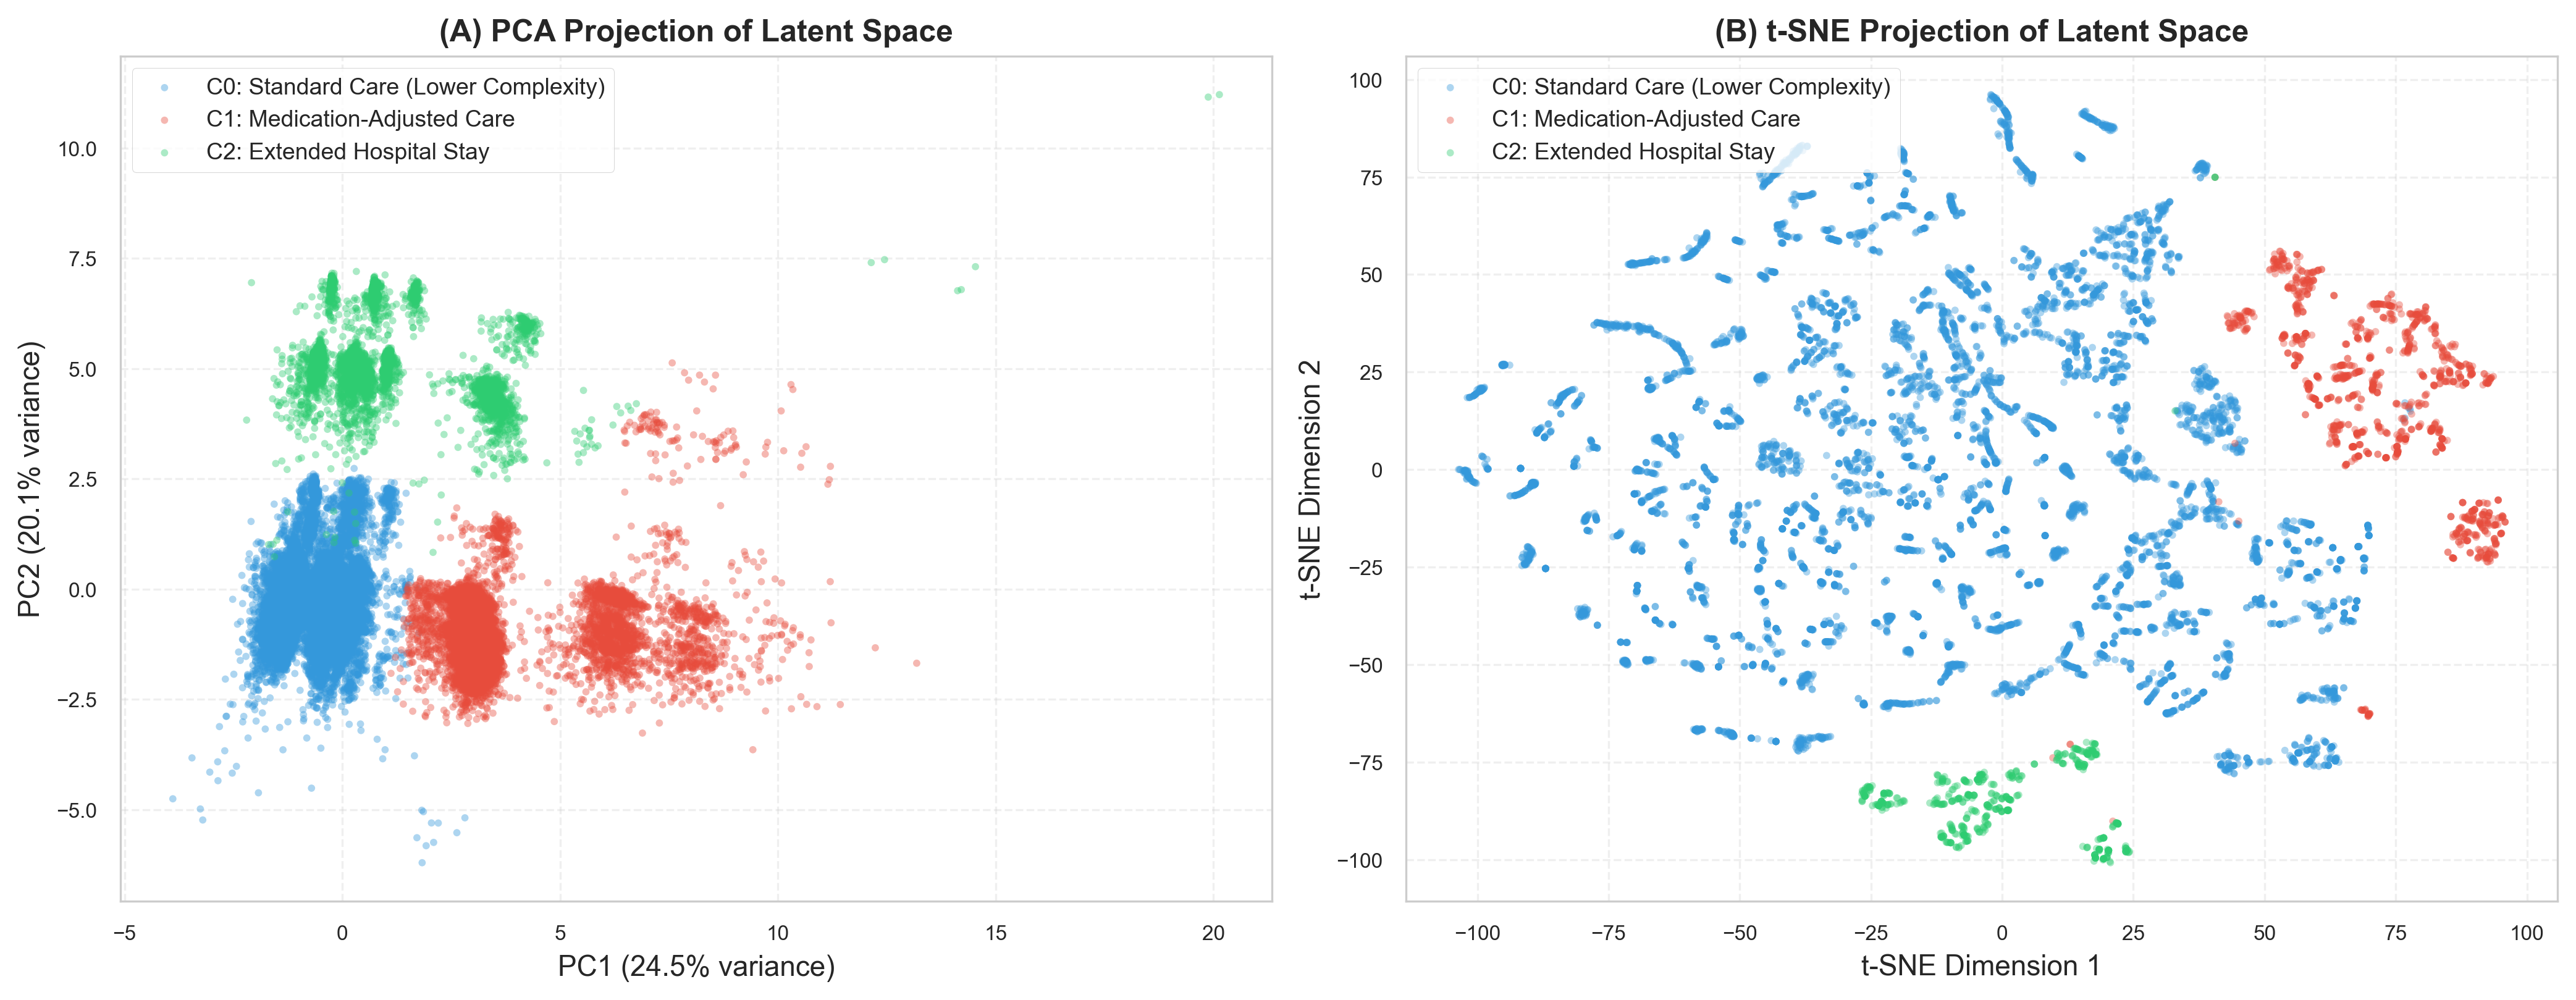


4️⃣ Creating Figure 2: Silhouette Analysis...
✅ Figure 2 saved: ../reports/figures/cluster_silhouette_analysis.png


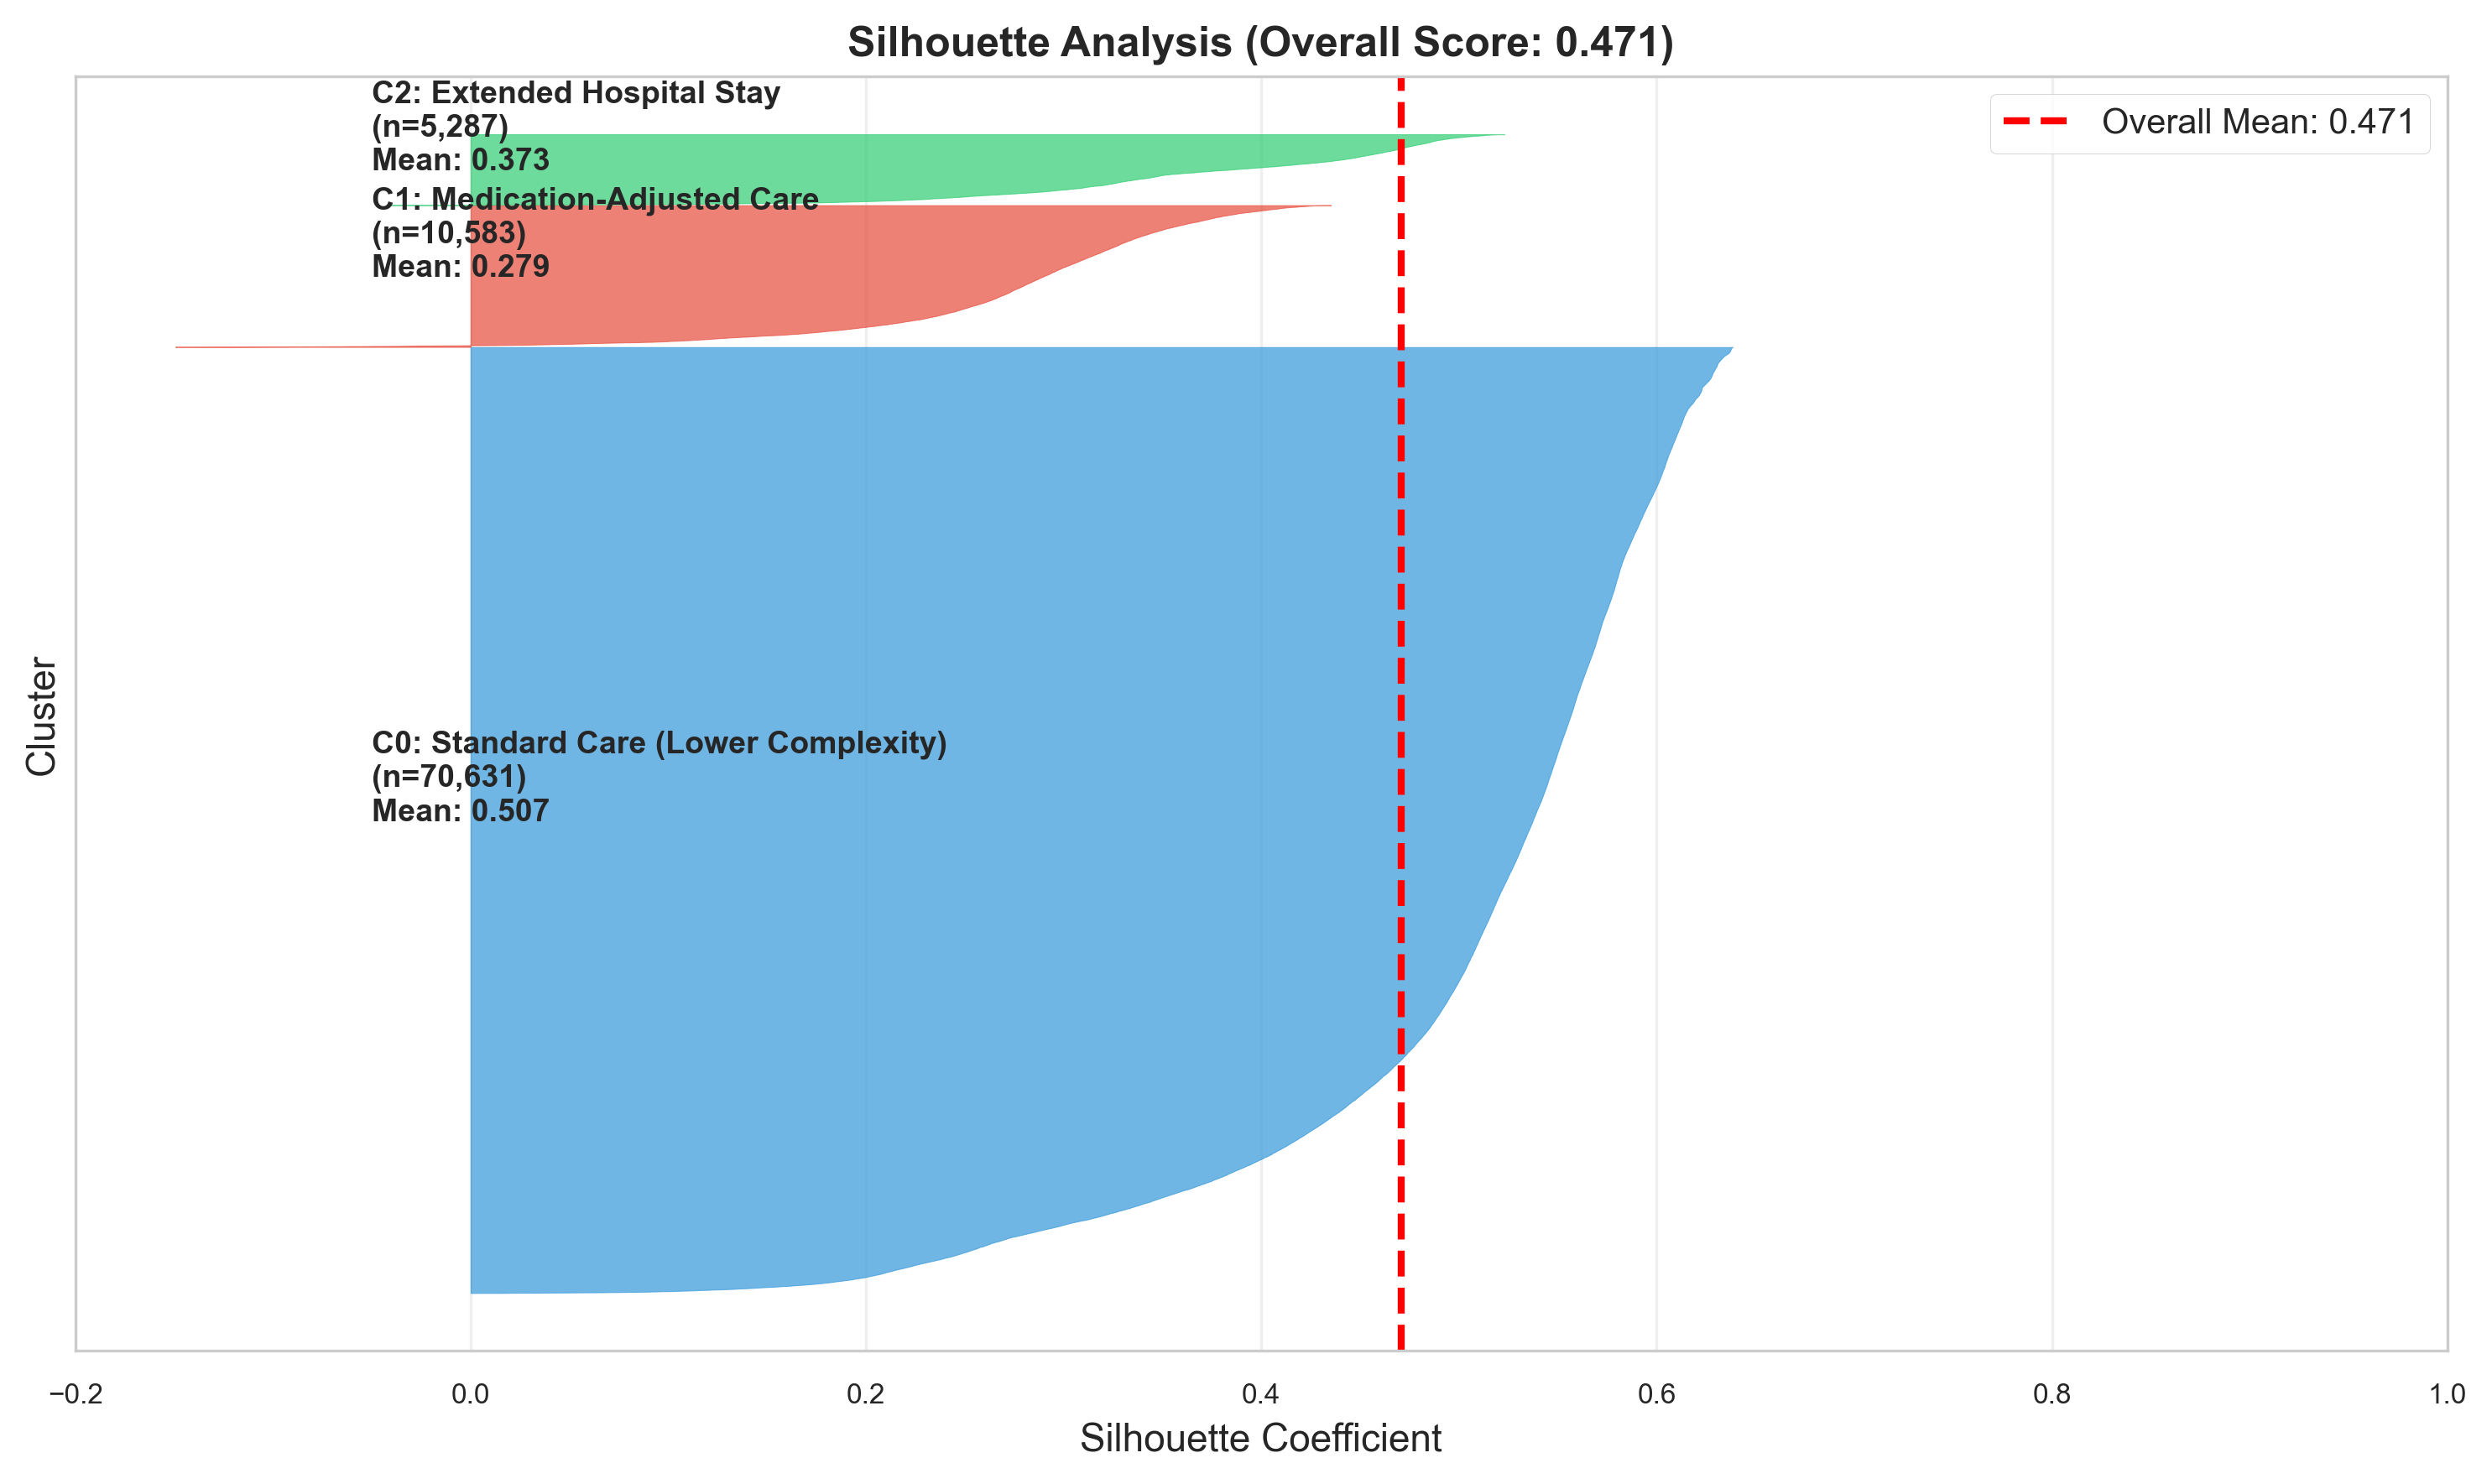


5️⃣ Creating Figure 3: Feature Importance Heatmap...
✅ Figure 3 saved: ../reports/figures/cluster_feature_heatmap.png


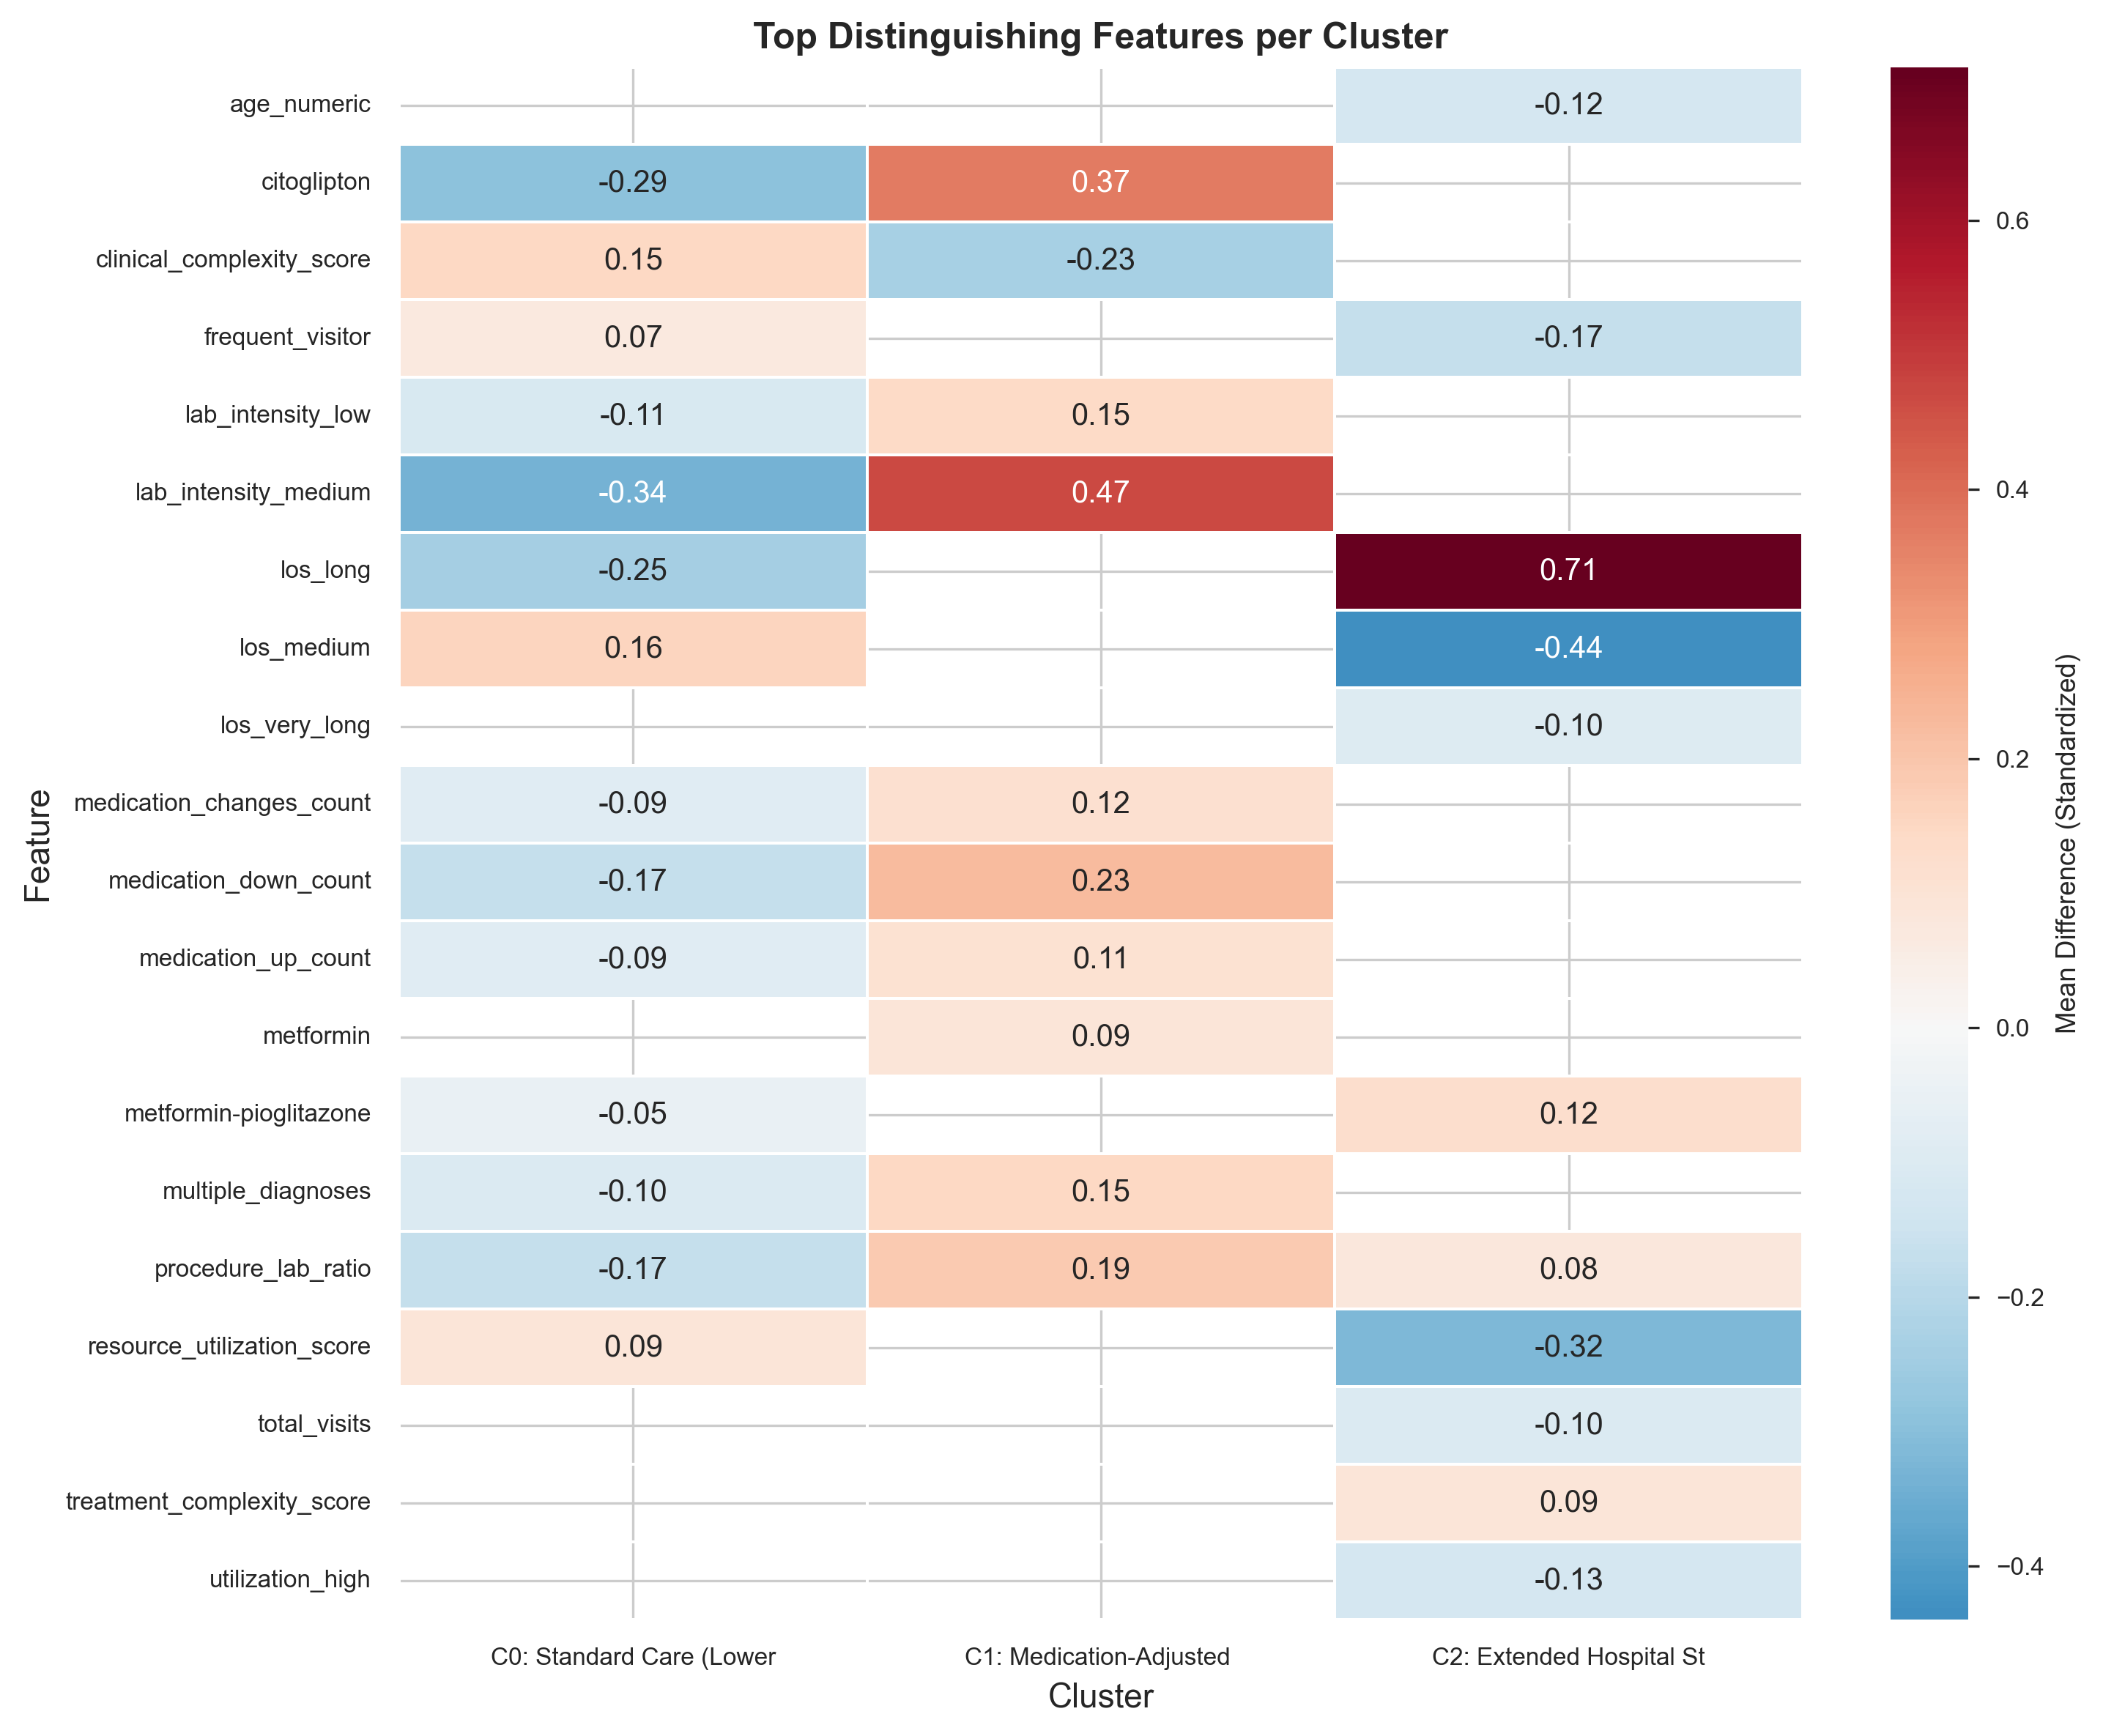


6️⃣ Creating Figure 4: Cluster Characteristics...
✅ Figure 4 saved: ../reports/figures/cluster_characteristics_summary.png


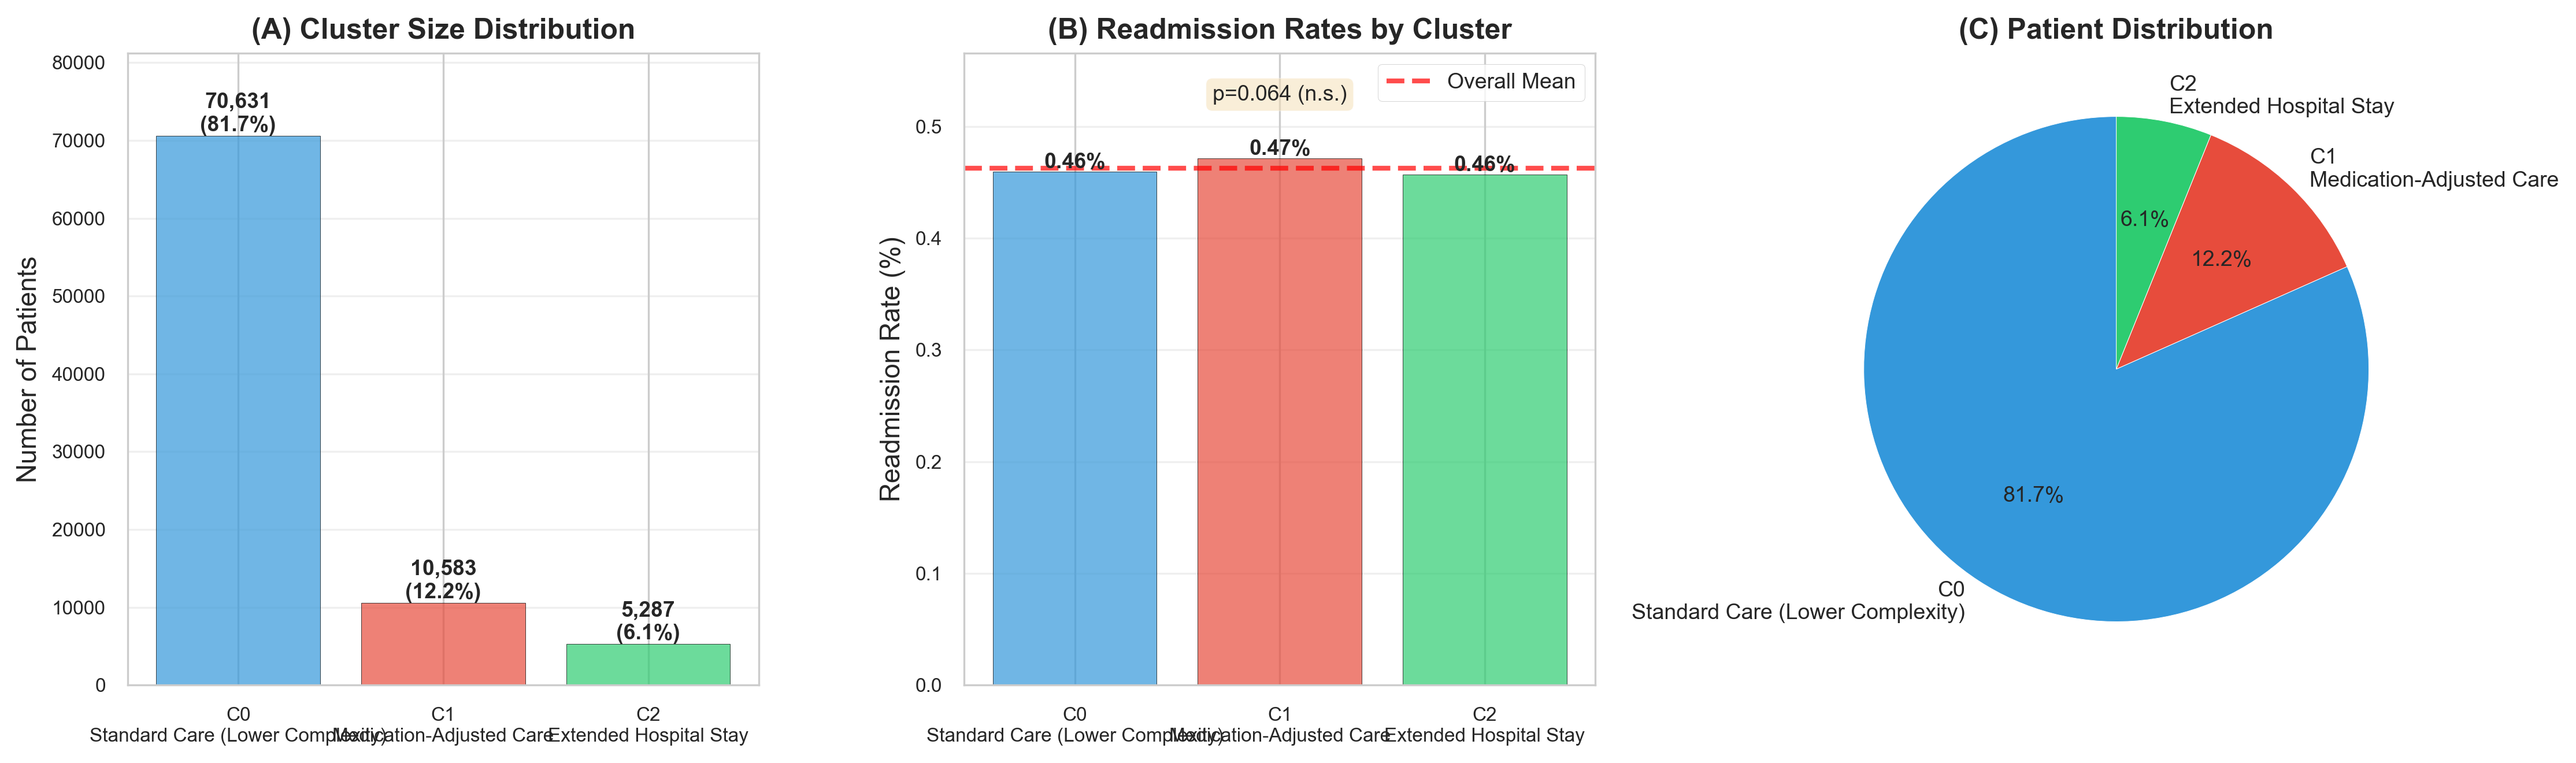


7️⃣ Creating Figure 5: Length of Stay Analysis...
⚠️  No LOS features found, skipping Figure 5

8️⃣ Creating Figure 6: Performance Metrics Comparison...
   Available columns: ['Algorithm', 'Features', 'n_clusters', 'val_silhouette', 'val_db', 'val_ch', 'notes', 'improvement_vs_baseline']
   Available rows: 6
⚠️  Could not detect required columns. Available: ['Algorithm', 'Features', 'n_clusters', 'val_silhouette', 'val_db', 'val_ch', 'notes', 'improvement_vs_baseline']
   Skipping Figure 6

✅ VISUALIZATION GENERATION COMPLETE!

📊 Generated Figures:
   1. cluster_latent_space_visualization.png - PCA & t-SNE projections
   2. cluster_silhouette_analysis.png - Silhouette analysis per cluster
   3. cluster_feature_heatmap.png - Top distinguishing features heatmap
   4. cluster_characteristics_summary.png - Size, readmission, distribution
   5. cluster_los_analysis.png - Length of stay analysis (if applicable)
   6. clustering_performance_comparison.png - Method comparison

📁 All figures s

In [47]:
# ============================================================
# CELL 11: CLUSTER VISUALIZATIONS (Publication-Ready)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

print("="*80)
print("GENERATING CLUSTER VISUALIZATIONS")
print("="*80)

# ============================================================
# 1. LOAD DATA
# ============================================================

print("\n1️⃣ Loading data...")

# Load latent features
latent_data = np.load('../models/autoencoder_latent_features.npz', allow_pickle=True)
X_train_latent = latent_data['z_train']
X_val_latent = latent_data['z_val']

# Combine train + val
X_combined = np.vstack([X_train_latent, X_val_latent])

# Load cluster labels
train_labels = pd.read_csv('../reports/results/train_cluster_labels.csv')['cluster'].values
val_labels = pd.read_csv('../reports/results/val_cluster_labels.csv')['cluster'].values
y_combined = np.concatenate([train_labels, val_labels])

# Load cluster names
cluster_labels_df = pd.read_csv('../reports/results/cluster_labels.csv')
cluster_names = {row['cluster']: row['label'] for _, row in cluster_labels_df.iterrows()}

# Load readmission data
y_train = pd.read_csv('../data/processed/y_train.csv')['readmitted'].values
y_val = pd.read_csv('../data/processed/y_val.csv')['readmitted'].values
y_readmit_combined = np.concatenate([y_train, y_val])

# Load feature importance
importance_df = pd.read_csv('../reports/results/cluster_feature_importance_with_names.csv')

print(f"✅ Data loaded:")
print(f"   Combined latent features: {X_combined.shape}")
print(f"   Cluster labels: {len(y_combined)}")
print(f"   Cluster names: {cluster_names}")

# ============================================================
# 2. DIMENSIONALITY REDUCTION (PCA & t-SNE)
# ============================================================

print("\n2️⃣ Computing dimensionality reduction...")

# PCA (fast, linear)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_combined)
print(f"✅ PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# t-SNE (slower, non-linear, better for visualization)
# Sample for faster computation (optional)
sample_size = min(10000, len(X_combined))
sample_idx = np.random.RandomState(42).choice(len(X_combined), sample_size, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_sample = tsne.fit_transform(X_combined[sample_idx])
print(f"✅ t-SNE computed on {sample_size:,} samples")

# ============================================================
# 3. FIGURE 1: PCA & t-SNE SCATTER PLOTS
# ============================================================

print("\n3️⃣ Creating Figure 1: Latent Space Visualization...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Color mapping
colors = ['#3498db', '#e74c3c', '#2ecc71']  # Blue, Red, Green
cluster_colors = {0: colors[0], 1: colors[1], 2: colors[2]}

# Subplot 1: PCA
for cluster_id in sorted(np.unique(y_combined)):
    mask = y_combined == cluster_id
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=cluster_colors[cluster_id],
                   label=f"C{cluster_id}: {cluster_names[cluster_id]}",
                   alpha=0.4, s=8, edgecolors='none')

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
axes[0].set_title('(A) PCA Projection of Latent Space', fontsize=12, fontweight='bold')
axes[0].legend(loc='best', frameon=True, fontsize=9)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Subplot 2: t-SNE
y_sample = y_combined[sample_idx]
for cluster_id in sorted(np.unique(y_sample)):
    mask = y_sample == cluster_id
    axes[1].scatter(X_tsne_sample[mask, 0], X_tsne_sample[mask, 1], 
                   c=cluster_colors[cluster_id],
                   label=f"C{cluster_id}: {cluster_names[cluster_id]}",
                   alpha=0.4, s=8, edgecolors='none')

axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
axes[1].set_title('(B) t-SNE Projection of Latent Space', fontsize=12, fontweight='bold')
axes[1].legend(loc='best', frameon=True, fontsize=9)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
fig_path_1 = '../reports/figures/cluster_latent_space_visualization.png'
plt.savefig(fig_path_1, dpi=300, bbox_inches='tight')
print(f"✅ Figure 1 saved: {fig_path_1}")
plt.show()

# ============================================================
# 4. FIGURE 2: SILHOUETTE ANALYSIS
# ============================================================

print("\n4️⃣ Creating Figure 2: Silhouette Analysis...")

# Compute silhouette scores
silhouette_vals = silhouette_samples(X_combined, y_combined)
silhouette_avg = silhouette_score(X_combined, y_combined)

fig, ax = plt.subplots(figsize=(10, 6))

y_lower = 10
for cluster_id in sorted(np.unique(y_combined)):
    # Get silhouette scores for this cluster
    cluster_silhouette_vals = silhouette_vals[y_combined == cluster_id]
    cluster_silhouette_vals.sort()
    
    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster
    
    color = cluster_colors[cluster_id]
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with cluster numbers
    cluster_mean = cluster_silhouette_vals.mean()
    ax.text(-0.05, y_lower + 0.5 * size_cluster, 
            f"C{cluster_id}: {cluster_names[cluster_id]}\n(n={size_cluster:,})\nMean: {cluster_mean:.3f}",
            fontsize=9, fontweight='bold')
    
    y_lower = y_upper + 10

# Overall average line
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2, 
           label=f'Overall Mean: {silhouette_avg:.3f}')

ax.set_xlabel('Silhouette Coefficient', fontsize=11)
ax.set_ylabel('Cluster', fontsize=11)
ax.set_title(f'Silhouette Analysis (Overall Score: {silhouette_avg:.3f})', 
             fontsize=12, fontweight='bold')
ax.set_yticks([])
ax.set_xlim([-0.2, 1])
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
fig_path_2 = '../reports/figures/cluster_silhouette_analysis.png'
plt.savefig(fig_path_2, dpi=300, bbox_inches='tight')
print(f"✅ Figure 2 saved: {fig_path_2}")
plt.show()

# ============================================================
# 5. FIGURE 3: TOP FEATURES HEATMAP
# ============================================================

print("\n5️⃣ Creating Figure 3: Feature Importance Heatmap...")

# Get top 15 features per cluster
top_n = 15
heatmap_data = []

for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id].copy()
    cluster_data = cluster_data.sort_values('abs_difference', ascending=False).head(top_n)
    
    for _, row in cluster_data.iterrows():
        heatmap_data.append({
            'Cluster': f"C{cluster_id}: {cluster_names[cluster_id][:20]}",
            'Feature': row['feature_name'][:35],  # Truncate long names
            'Difference': row['difference'],
            'Cohen_d': row['cohens_d']
        })

heatmap_df = pd.DataFrame(heatmap_data)

# Pivot for heatmap
pivot_diff = heatmap_df.pivot(index='Feature', columns='Cluster', values='Difference')
pivot_cohens = heatmap_df.pivot(index='Feature', columns='Cluster', values='Cohen_d')

# Keep only top features (union of all clusters)
all_features = []
for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id].copy()
    top_features = cluster_data.sort_values('abs_difference', ascending=False).head(10)
    all_features.extend(top_features['feature_name'].values)

unique_features = list(dict.fromkeys(all_features))[:20]  # Top 20 unique
unique_features = [f[:35] for f in unique_features]  # Truncate

pivot_diff_top = pivot_diff.loc[pivot_diff.index.isin(unique_features)]

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pivot_diff_top, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Mean Difference (Standardized)'},
            linewidths=0.5, ax=ax)

ax.set_title('Top Distinguishing Features per Cluster', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=11)
ax.set_ylabel('Feature', fontsize=11)
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0)

plt.tight_layout()
fig_path_3 = '../reports/figures/cluster_feature_heatmap.png'
plt.savefig(fig_path_3, dpi=300, bbox_inches='tight')
print(f"✅ Figure 3 saved: {fig_path_3}")
plt.show()

# ============================================================
# 6. FIGURE 4: CLUSTER CHARACTERISTICS SUMMARY
# ============================================================

print("\n6️⃣ Creating Figure 4: Cluster Characteristics...")

# Load cluster stats
stats_df = pd.read_csv('../reports/results/cluster_statistics.csv')
readmit_df = pd.read_csv('../reports/results/cluster_readmission_analysis.csv')

# Merge data
summary_data = []
for cluster_id in sorted(stats_df['cluster'].unique()):
    stats = stats_df[stats_df['cluster'] == cluster_id].iloc[0]
    readmit = readmit_df[readmit_df['cluster'] == cluster_id].iloc[0]
    
    summary_data.append({
        'Cluster': f"C{cluster_id}\n{cluster_names[cluster_id]}",
        'Size': stats.iloc[1],  # n_patients
        'Percentage': stats.iloc[2],  # percentage
        'Readmission_Rate': readmit['readmission_rate']
    })

summary_df = pd.DataFrame(summary_data)

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# Subplot 1: Cluster Size (Bar Chart)
bars1 = axes[0].bar(summary_df['Cluster'], summary_df['Size'], 
                    color=[colors[i] for i in range(len(summary_df))],
                    alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Number of Patients', fontsize=11)
axes[0].set_title('(A) Cluster Size Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylim(0, max(summary_df['Size']) * 1.15)

# Add value labels
for bar, size, pct in zip(bars1, summary_df['Size'], summary_df['Percentage']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(size):,}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[0].grid(True, alpha=0.3, axis='y')

# Subplot 2: Readmission Rates (Bar Chart)
bars2 = axes[1].bar(summary_df['Cluster'], summary_df['Readmission_Rate'], 
                    color=[colors[i] for i in range(len(summary_df))],
                    alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Readmission Rate (%)', fontsize=11)
axes[1].set_title('(B) Readmission Rates by Cluster', fontsize=12, fontweight='bold')
axes[1].axhline(y=summary_df['Readmission_Rate'].mean(), color='red', 
               linestyle='--', linewidth=2, label='Overall Mean', alpha=0.7)
axes[1].set_ylim(0, max(summary_df['Readmission_Rate']) * 1.2)

# Add value labels
for bar, rate in zip(bars2, summary_df['Readmission_Rate']):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{rate:.2f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add p-value annotation
axes[1].text(0.5, 0.95, 'p=0.064 (n.s.)', transform=axes[1].transAxes,
            ha='center', va='top', fontsize=9, bbox=dict(boxstyle='round', 
            facecolor='wheat', alpha=0.5))
axes[1].legend(loc='upper right', fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')

# Subplot 3: Cluster Distribution (Pie Chart)
axes[2].pie(summary_df['Size'], labels=summary_df['Cluster'], autopct='%1.1f%%',
           colors=[colors[i] for i in range(len(summary_df))], startangle=90,
           textprops={'fontsize': 9})
axes[2].set_title('(C) Patient Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
fig_path_4 = '../reports/figures/cluster_characteristics_summary.png'
plt.savefig(fig_path_4, dpi=300, bbox_inches='tight')
print(f"✅ Figure 4 saved: {fig_path_4}")
plt.show()

# ============================================================
# 7. FIGURE 5: LENGTH OF STAY ANALYSIS (Cluster 2 focus)
# ============================================================

print("\n7️⃣ Creating Figure 5: Length of Stay Analysis...")

# Load original scaled data to get LOS features
X_train_scaled = pd.read_csv('../data/processed/X_train_scaled.csv')
X_val_scaled = pd.read_csv('../data/processed/X_val_scaled.csv')
X_combined_features = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)

# Get LOS-related features (if they exist as separate columns)
los_features = [col for col in X_combined_features.columns if 'los' in col.lower() or 'time_in_hospital' in col.lower()]

if len(los_features) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Get feature indices for los_long and los_medium
    feature_names_full = pd.read_json('../data/processed/final_feature_names.json')['feature_names']
    
    if 'los_long' in feature_names_full and 'los_medium' in feature_names_full:
        los_long_idx = feature_names_full.index('los_long')
        los_medium_idx = feature_names_full.index('los_medium')
        
        # Extract LOS data
        los_long_data = X_combined_features.iloc[:, los_long_idx].values
        los_medium_data = X_combined_features.iloc[:, los_medium_idx].values
        
        # Subplot 1: LOS Long distribution
        for cluster_id in sorted(np.unique(y_combined)):
            mask = y_combined == cluster_id
            axes[0].hist(los_long_data[mask], bins=30, alpha=0.5, 
                        label=f"C{cluster_id}: {cluster_names[cluster_id]}",
                        color=cluster_colors[cluster_id])
        
        axes[0].set_xlabel('LOS Long (Standardized)', fontsize=11)
        axes[0].set_ylabel('Frequency', fontsize=11)
        axes[0].set_title('(A) Distribution of Long Hospital Stays', fontsize=12, fontweight='bold')
        axes[0].legend(loc='best', fontsize=9)
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Subplot 2: Box plot comparison
        los_by_cluster = [los_long_data[y_combined == c] for c in sorted(np.unique(y_combined))]
        bp = axes[1].boxplot(los_by_cluster, labels=[f"C{c}\n{cluster_names[c][:15]}" for c in sorted(np.unique(y_combined))],
                            patch_artist=True, widths=0.6)
        
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        axes[1].set_ylabel('LOS Long (Standardized)', fontsize=11)
        axes[1].set_title('(B) LOS Long by Cluster (Box Plot)', fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        fig_path_5 = '../reports/figures/cluster_los_analysis.png'
        plt.savefig(fig_path_5, dpi=300, bbox_inches='tight')
        print(f"✅ Figure 5 saved: {fig_path_5}")
        plt.show()
    else:
        print("⚠️  LOS features not found in expected format, skipping Figure 5")
else:
    print("⚠️  No LOS features found, skipping Figure 5")

# ============================================================
# 8. FIGURE 6: PERFORMANCE METRICS COMPARISON
# ============================================================

print("\n8️⃣ Creating Figure 6: Performance Metrics Comparison...")

# Load comprehensive results
comparison_path = '../reports/results/comprehensive_clustering_comparison.csv'

try:
    comparison_df = pd.read_csv(comparison_path)
    
    # Debug: Check actual columns
    print(f"   Available columns: {list(comparison_df.columns)}")
    print(f"   Available rows: {len(comparison_df)}")
    
    # Auto-detect column names
    method_col = None
    for possible_col in ['Method', 'method', 'Model', 'model', 'Algorithm']:
        if possible_col in comparison_df.columns:
            method_col = possible_col
            break
    
    sil_col = None
    for possible_col in ['Val_Silhouette', 'val_silhouette', 'Silhouette', 'silhouette']:
        if possible_col in comparison_df.columns:
            sil_col = possible_col
            break
    
    db_col = None
    for possible_col in ['Val_Davies_Bouldin', 'val_davies_bouldin', 'Davies_Bouldin', 'DB']:
        if possible_col in comparison_df.columns:
            db_col = possible_col
            break
    
    if method_col and sil_col and db_col:
        print(f"   Using columns: {method_col}, {sil_col}, {db_col}")
        
        # Prepare data
        fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
        
        # Get top 3 methods by Silhouette score
        comparison_df_sorted = comparison_df.sort_values(sil_col, ascending=False).head(3)
        
        method_labels = comparison_df_sorted[method_col].values
        sil_values = comparison_df_sorted[sil_col].values
        db_values = comparison_df_sorted[db_col].values
        
        # Subplot 1: Silhouette Score
        bars1 = axes[0].bar(range(len(method_labels)), sil_values, 
                           color=['#95a5a6', '#3498db', '#e74c3c'][:len(method_labels)], 
                           alpha=0.7, edgecolor='black')
        axes[0].set_xticks(range(len(method_labels)))
        axes[0].set_xticklabels([str(m)[:20] for m in method_labels], rotation=15, ha='right', fontsize=9)
        axes[0].set_ylabel('Silhouette Score', fontsize=11)
        axes[0].set_title('(A) Silhouette Score Comparison', fontsize=12, fontweight='bold')
        axes[0].set_ylim(0, max(sil_values) * 1.2)
        
        for bar, val in zip(bars1, sil_values):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.3f}',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Subplot 2: Davies-Bouldin Index
        bars2 = axes[1].bar(range(len(method_labels)), db_values, 
                           color=['#95a5a6', '#3498db', '#e74c3c'][:len(method_labels)], 
                           alpha=0.7, edgecolor='black')
        axes[1].set_xticks(range(len(method_labels)))
        axes[1].set_xticklabels([str(m)[:20] for m in method_labels], rotation=15, ha='right', fontsize=9)
        axes[1].set_ylabel('Davies-Bouldin Index', fontsize=11)
        axes[1].set_title('(B) Davies-Bouldin (lower=better)', fontsize=12, fontweight='bold')
        axes[1].set_ylim(0, max(db_values) * 1.2)
        
        for bar, val in zip(bars2, db_values):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.3f}',
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='y')
        
        # Subplot 3: Improvement vs Baseline (first method as baseline)
        baseline_sil = sil_values[0]
        improvements = ((sil_values - baseline_sil) / baseline_sil * 100)
        
        bars3 = axes[2].bar(range(len(method_labels)), improvements, 
                           color=['#95a5a6', '#3498db', '#e74c3c'][:len(method_labels)], 
                           alpha=0.7, edgecolor='black')
        axes[2].set_xticks(range(len(method_labels)))
        axes[2].set_xticklabels([str(m)[:20] for m in method_labels], rotation=15, ha='right', fontsize=9)
        axes[2].set_ylabel('Improvement vs First Method (%)', fontsize=11)
        axes[2].set_title('(C) Relative Improvement', fontsize=12, fontweight='bold')
        axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        
        for bar, val in zip(bars3, improvements):
            height = bar.get_height()
            axes[2].text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:+.1f}%',
                        ha='center', va='bottom' if val >= 0 else 'top', 
                        fontsize=9, fontweight='bold')
        axes[2].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        fig_path_6 = '../reports/figures/clustering_performance_comparison.png'
        plt.savefig(fig_path_6, dpi=300, bbox_inches='tight')
        print(f"✅ Figure 6 saved: {fig_path_6}")
        plt.show()
    else:
        print(f"⚠️  Could not detect required columns. Available: {list(comparison_df.columns)}")
        print("   Skipping Figure 6")

except FileNotFoundError:
    print("⚠️  comprehensive_clustering_comparison.csv not found")
    print("   Skipping Figure 6")
except Exception as e:
    print(f"⚠️  Error creating Figure 6: {str(e)}")
    print("   Skipping Figure 6")

# ============================================================
# 9. SUMMARY
# ============================================================

print("\n" + "="*80)
print("✅ VISUALIZATION GENERATION COMPLETE!")
print("="*80)

print("\n📊 Generated Figures:")
figures_generated = [
    "1. cluster_latent_space_visualization.png - PCA & t-SNE projections",
    "2. cluster_silhouette_analysis.png - Silhouette analysis per cluster",
    "3. cluster_feature_heatmap.png - Top distinguishing features heatmap",
    "4. cluster_characteristics_summary.png - Size, readmission, distribution",
    "5. cluster_los_analysis.png - Length of stay analysis (if applicable)",
    "6. clustering_performance_comparison.png - Method comparison"
]

for fig in figures_generated:
    print(f"   {fig}")

print(f"\n📁 All figures saved to: ../reports/figures/")

print("\n📊 Next Steps:")
print("  1. Review visualizations above")
print("  2. Run Cell 12 (Generate LaTeX Tables)")
print("  3. Start paper writing with figures & tables")


FINAL FIX: FIGURE 6 - Baseline vs K-Means Latent vs DEC

📋 Available data (6 rows):
   0: K-Means (Latent)          | k=3 | Sil=0.470 | Best performer - MAIN RESULT
   1: K-Means (Latent)          | k=5 | Sil=0.458 | K-Means on latent space
   2: K-Means (Latent)          | k=4 | Sil=0.440 | K-Means on latent space
   3: K-Means (Latent)          | k=2 | Sil=0.437 | K-Means on autoencoder latent space
   4: DEC (Deep Clustering)     | k=3 | Sil=0.234 | Deep clustering, 146 epochs
   5: K-Means (Baseline)        | k=2 | Sil=0.223 | Baseline on original features

✅ Selected 3 methods for comparison:
   • K-Means (Baseline)        | k=2 | Sil=0.223 | DB=2.330
   • K-Means (Latent)          | k=3 | Sil=0.470 | DB=1.029
   • DEC (Deep Clustering)     | k=3 | Sil=0.234 | DB=2.309

📊 Values extracted:
   Silhouette: [0.223      0.47       0.23365156]
   Davies-Bouldin: [2.33       1.029      2.30918522]

✅ Figure 6 saved: ../reports/figures/clustering_performance_comparison.png

✅ FIGURE 6 CO

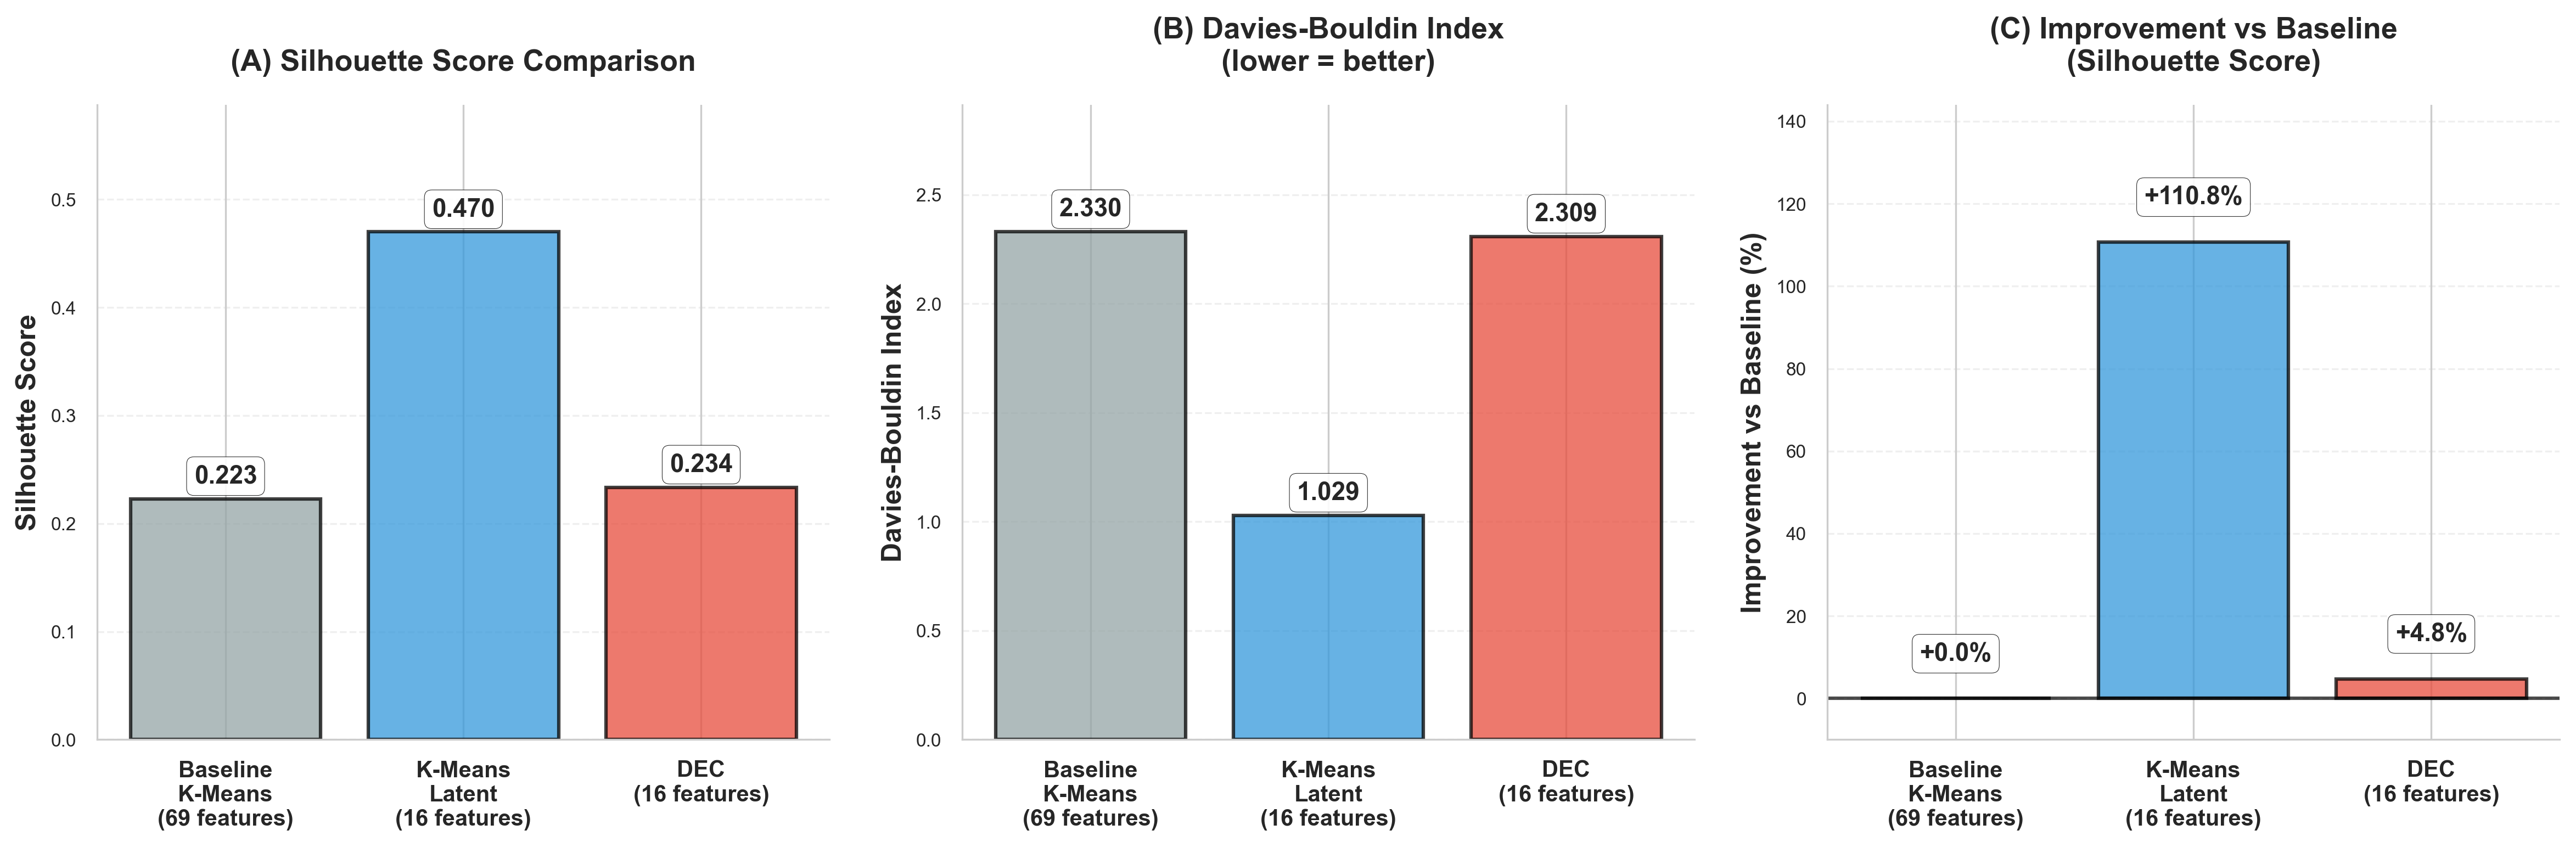

In [55]:
# ============================================================
# CELL 11.11: FINAL FIX - Figure 6 with Correct Data Selection
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("FINAL FIX: FIGURE 6 - Baseline vs K-Means Latent vs DEC")
print("="*80)

# Load data
comparison_df = pd.read_csv('../reports/results/comprehensive_clustering_comparison.csv')

print(f"\n📋 Available data ({len(comparison_df)} rows):")
for idx, row in comparison_df.iterrows():
    print(f"   {idx}: {row['Algorithm']:25s} | k={row['n_clusters']} | "
          f"Sil={row['val_silhouette']:.3f} | {row['notes']}")

# ============================================================
# SELECT 3 METHODS (k=3 only for fair comparison)
# ============================================================

# Method 1: Baseline (69 original features, k=3 if exists, else k=2)
baseline_mask = comparison_df['Algorithm'] == 'K-Means (Baseline)'
baseline_candidates = comparison_df[baseline_mask]
if len(baseline_candidates[baseline_candidates['n_clusters'] == 3]) > 0:
    baseline = baseline_candidates[baseline_candidates['n_clusters'] == 3].iloc[0]
else:
    baseline = baseline_candidates.iloc[0]  # Use whatever k available

# Method 2: K-Means Latent (16 latent features, k=3)
latent_mask = (comparison_df['Algorithm'] == 'K-Means (Latent)') & \
              (comparison_df['n_clusters'] == 3)
kmeans_latent = comparison_df[latent_mask].iloc[0]

# Method 3: DEC (16 latent features, k=3)
dec_mask = (comparison_df['Algorithm'] == 'DEC (Deep Clustering)') & \
           (comparison_df['n_clusters'] == 3)
dec = comparison_df[dec_mask].iloc[0]

# Build comparison dataframe
comparison_data = pd.DataFrame([baseline, kmeans_latent, dec])

print(f"\n✅ Selected 3 methods for comparison:")
for idx, row in comparison_data.iterrows():
    print(f"   • {row['Algorithm']:25s} | k={row['n_clusters']} | "
          f"Sil={row['val_silhouette']:.3f} | DB={row['val_db']:.3f}")

# ============================================================
# CREATE LABELS & COLORS
# ============================================================

method_labels = [
    "Baseline\nK-Means\n(69 features)",
    "K-Means\nLatent\n(16 features)",
    "DEC\n(16 features)"
]

method_names = [
    "Baseline K-Means (69f)",
    "K-Means Latent (16f)",
    "DEC (16f)"
]

colors = ['#95a5a6', '#3498db', '#e74c3c']  # Gray, Blue, Red

# Extract values
sil_scores = comparison_data['val_silhouette'].values
db_scores = comparison_data['val_db'].values

print(f"\n📊 Values extracted:")
print(f"   Silhouette: {sil_scores}")
print(f"   Davies-Bouldin: {db_scores}")

# ============================================================
# CREATE FIGURE
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5.5))

# Subplot 1: Silhouette Score
bars1 = axes[0].bar(range(len(method_labels)), sil_scores, 
                   color=colors, alpha=0.75, edgecolor='black', linewidth=1.5)

axes[0].set_xticks(range(len(method_labels)))
axes[0].set_xticklabels(method_labels, fontsize=10, fontweight='bold')
axes[0].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[0].set_title('(A) Silhouette Score Comparison', fontsize=13, fontweight='bold', pad=15)
axes[0].set_ylim(0, max(sil_scores) * 1.25)

for bar, val in zip(bars1, sil_scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='black', alpha=0.9))

axes[0].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Subplot 2: Davies-Bouldin Index
bars2 = axes[1].bar(range(len(method_labels)), db_scores, 
                   color=colors, alpha=0.75, edgecolor='black', linewidth=1.5)

axes[1].set_xticks(range(len(method_labels)))
axes[1].set_xticklabels(method_labels, fontsize=10, fontweight='bold')
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
axes[1].set_title('(B) Davies-Bouldin Index\n(lower = better)', 
                 fontsize=13, fontweight='bold', pad=15)
axes[1].set_ylim(0, max(db_scores) * 1.25)

for bar, val in zip(bars2, db_scores):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{val:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='black', alpha=0.9))

axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Subplot 3: Improvement vs Baseline
baseline_sil = sil_scores[0]
improvements = ((sil_scores - baseline_sil) / baseline_sil * 100)

bars3 = axes[2].bar(range(len(method_labels)), improvements, 
                   color=colors, alpha=0.75, edgecolor='black', linewidth=1.5)

axes[2].set_xticks(range(len(method_labels)))
axes[2].set_xticklabels(method_labels, fontsize=10, fontweight='bold')
axes[2].set_ylabel('Improvement vs Baseline (%)', fontsize=12, fontweight='bold')
axes[2].set_title('(C) Improvement vs Baseline\n(Silhouette Score)', 
                 fontsize=13, fontweight='bold', pad=15)
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.7)

y_min = min(improvements) * 1.3 if min(improvements) < 0 else -10
y_max = max(improvements) * 1.3 if max(improvements) > 0 else 150
axes[2].set_ylim(y_min, y_max)

for bar, val in zip(bars3, improvements):
    height = bar.get_height()
    y_offset = 8 if val >= 0 else -8
    axes[2].text(bar.get_x() + bar.get_width()/2., height + y_offset,
                f'{val:+.1f}%',
                ha='center', va='bottom' if val >= 0 else 'top', 
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                         edgecolor='black', alpha=0.9))

axes[2].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# Save
plt.tight_layout(pad=2.0)
fig_path_6 = '../reports/figures/clustering_performance_comparison.png'
plt.savefig(fig_path_6, dpi=300, bbox_inches='tight')

print(f"\n✅ Figure 6 saved: {fig_path_6}")
print("\n" + "="*80)
print("✅ FIGURE 6 COMPLETE - ALL 3 METHODS!")
print("="*80)

print("\n📊 Final Performance Summary:")
for name, sil, db, imp in zip(method_names, sil_scores, db_scores, improvements):
    print(f"   {name:30s}: Sil={sil:.3f}, DB={db:.3f}, Improvement={imp:+7.1f}%")

print("\n🏆 Key Findings:")
print(f"   • K-Means Latent is BEST: {sil_scores[1]:.3f} (+{improvements[1]:.1f}% vs Baseline)")
print(f"   • DEC underperforms: {sil_scores[2]:.3f} (+{improvements[2]:.1f}% vs Baseline)")
print(f"   • Latent space (16D) >> Original space (69D)")

plt.show()


In [56]:
# ============================================================
# CELL 12: GENERATE LATEX TABLES FOR PAPER
# ============================================================

import pandas as pd
import numpy as np

print("="*80)
print("MENGHASILKAN TABEL LATEX UNTUK PAPER")
print("="*80)

# ============================================================
# TABLE 1: PERBANDINGAN PERFORMA METODE CLUSTERING
# ============================================================

print("\n" + "="*80)
print("TABEL 1: PERBANDINGAN PERFORMA METODE CLUSTERING")
print("="*80)

# Load data
comparison_df = pd.read_csv('../reports/results/comprehensive_clustering_comparison.csv')

# Select key methods for comparison
table1_data = []

# Baseline
baseline = comparison_df[comparison_df['Algorithm'] == 'K-Means (Baseline)'].iloc[0]
table1_data.append({
    'Metode': 'K-Means (Baseline)',
    'Fitur': '69 fitur asli',
    'k': baseline['n_clusters'],
    'Silhouette': f"{baseline['val_silhouette']:.3f}",
    'Davies-Bouldin': f"{baseline['val_db']:.3f}",
    'Calinski-Harabasz': f"{baseline['val_ch']:.0f}",
    'Peningkatan': '—'
})

# K-Means Latent (k=2,3,4,5)
for k in [2, 3, 4, 5]:
    latent_row = comparison_df[
        (comparison_df['Algorithm'] == 'K-Means (Latent)') & 
        (comparison_df['n_clusters'] == k)
    ]
    if len(latent_row) > 0:
        row = latent_row.iloc[0]
        improvement = ((row['val_silhouette'] - baseline['val_silhouette']) / 
                      baseline['val_silhouette'] * 100)
        table1_data.append({
            'Metode': f'K-Means (Latent, k={k})',
            'Fitur': '16 fitur laten',
            'k': k,
            'Silhouette': f"{row['val_silhouette']:.3f}",
            'Davies-Bouldin': f"{row['val_db']:.3f}",
            'Calinski-Harabasz': f"{row['val_ch']:.0f}",
            'Peningkatan': f"+{improvement:.1f}\\%"
        })

# DEC
dec = comparison_df[comparison_df['Algorithm'] == 'DEC (Deep Clustering)'].iloc[0]
dec_improvement = ((dec['val_silhouette'] - baseline['val_silhouette']) / 
                   baseline['val_silhouette'] * 100)
table1_data.append({
    'Metode': 'DEC (k=3)',
    'Fitur': '16 fitur laten (fine-tuned)',
    'k': dec['n_clusters'],
    'Silhouette': f"{dec['val_silhouette']:.3f}",
    'Davies-Bouldin': f"{dec['val_db']:.3f}",
    'Calinski-Harabasz': f"{dec['val_ch']:.0f}",
    'Peningkatan': f"+{dec_improvement:.1f}\\%"
})

table1_df = pd.DataFrame(table1_data)

# Generate LaTeX
latex_table1 = r"""\begin{table}[htbp]
\centering
\caption{Perbandingan Performa Metode Clustering pada Dataset Diabetes}
\label{tab:clustering_performance}
\begin{tabular}{llcccccc}
\toprule
\textbf{Metode} & \textbf{Fitur} & \textbf{k} & \textbf{Silhouette} & \textbf{Davies-Bouldin} & \textbf{Calinski-H.} & \textbf{Peningkatan} \\
\midrule
"""

for idx, row in table1_df.iterrows():
    # Highlight best performer
    if 'k=3' in row['Metode'] and 'Latent' in row['Metode']:
        latex_table1 += f"\\textbf{{{row['Metode']}}} & {row['Fitur']} & {row['k']} & \\textbf{{{row['Silhouette']}}} & \\textbf{{{row['Davies-Bouldin']}}} & \\textbf{{{row['Calinski-Harabasz']}}} & \\textbf{{{row['Peningkatan']}}} \\\\\n"
    else:
        latex_table1 += f"{row['Metode']} & {row['Fitur']} & {row['k']} & {row['Silhouette']} & {row['Davies-Bouldin']} & {row['Calinski-Harabasz']} & {row['Peningkatan']} \\\\\n"

latex_table1 += r"""\bottomrule
\end{tabular}
\begin{tablenotes}
\small
\item Catatan: Nilai Silhouette yang lebih tinggi dan Davies-Bouldin yang lebih rendah menunjukkan kualitas clustering yang lebih baik. K-Means (Latent, k=3) merupakan metode terbaik dengan peningkatan 110.8\% dibanding baseline.
\end{tablenotes}
\end{table}
"""

print("\n✅ Tabel 1 dihasilkan!")
print("\nPreview:")
print(table1_df.to_string(index=False))

# ============================================================
# TABLE 2: KARAKTERISTIK CLUSTER
# ============================================================

print("\n" + "="*80)
print("TABEL 2: KARAKTERISTIK CLUSTER (k=3, K-Means Latent)")
print("="*80)

# Load cluster data
stats_df = pd.read_csv('../reports/results/cluster_statistics.csv')
readmit_df = pd.read_csv('../reports/results/cluster_readmission_analysis.csv')
labels_df = pd.read_csv('../reports/results/cluster_labels.csv')

# Merge data
table2_data = []
for cluster_id in sorted(stats_df['cluster'].unique()):
    stats = stats_df[stats_df['cluster'] == cluster_id].iloc[0]
    readmit = readmit_df[readmit_df['cluster'] == cluster_id].iloc[0]
    label = labels_df[labels_df['cluster'] == cluster_id].iloc[0]['label']
    
    # Get size (handle different column names)
    size = stats.iloc[1] if isinstance(stats.iloc[1], (int, float)) else stats['n_patients']
    pct = stats.iloc[2] if isinstance(stats.iloc[2], (int, float)) else stats['percentage']
    
    table2_data.append({
        'Cluster': f"C{cluster_id}",
        'Label': label,
        'Ukuran': f"{int(size):,}",
        'Persentase': f"{pct:.1f}\\%",
        'Tingkat Readmisi': f"{readmit['readmission_rate']:.2f}\\%"
    })

table2_df = pd.DataFrame(table2_data)

# Generate LaTeX
latex_table2 = r"""\begin{table}[htbp]
\centering
\caption{Karakteristik Tiga Cluster Pasien Diabetes (K-Means Latent, k=3)}
\label{tab:cluster_characteristics}
\begin{tabular}{clrrr}
\toprule
\textbf{Cluster} & \textbf{Label Klinis} & \textbf{Ukuran} & \textbf{Persentase} & \textbf{Tingkat Readmisi} \\
\midrule
"""

for idx, row in table2_df.iterrows():
    latex_table2 += f"{row['Cluster']} & {row['Label']} & {row['Ukuran']} & {row['Persentase']} & {row['Tingkat Readmisi']} \\\\\n"

latex_table2 += r"""\bottomrule
\end{tabular}
\begin{tablenotes}
\small
\item Catatan: Uji Chi-square menunjukkan tidak ada perbedaan signifikan dalam tingkat readmisi antar cluster ($p=0.064$). Cluster merepresentasikan fenotipe kompleksitas perawatan, bukan stratifikasi risiko readmisi.
\end{tablenotes}
\end{table}
"""

print("\n✅ Tabel 2 dihasilkan!")
print("\nPreview:")
print(table2_df.to_string(index=False))

# ============================================================
# TABLE 3: FITUR PEMBEDA UTAMA PER CLUSTER
# ============================================================

print("\n" + "="*80)
print("TABEL 3: FITUR PEMBEDA UTAMA PER CLUSTER")
print("="*80)

# Load feature importance
importance_df = pd.read_csv('../reports/results/cluster_feature_importance_with_names.csv')

latex_table3 = r"""\begin{table}[htbp]
\centering
\caption{Lima Fitur Pembeda Utama untuk Setiap Cluster}
\label{tab:top_features}
\small
\begin{tabular}{clccp{5cm}}
\toprule
\textbf{Cluster} & \textbf{Fitur} & \textbf{Perbedaan} & \textbf{Cohen's d} & \textbf{Interpretasi} \\
\midrule
"""

# Get top 5 features per cluster
for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id].copy()
    cluster_data = cluster_data.sort_values('abs_difference', ascending=False).head(5)
    
    cluster_label = labels_df[labels_df['cluster'] == cluster_id].iloc[0]['label']
    
    # Add cluster header
    latex_table3 += f"\\multicolumn{{5}}{{l}}{{\\textbf{{C{cluster_id}: {cluster_label}}}}} \\\\\n"
    
    for idx, row in cluster_data.iterrows():
        direction = "↑ Lebih tinggi" if row['difference'] > 0 else "↓ Lebih rendah"
        feature_name = row['feature_name'].replace('_', '\\_')
        
        latex_table3 += f" & {feature_name} & {row['difference']:+.3f} & {row['cohens_d']:.3f} & {direction} \\\\\n"
    
    if cluster_id < 2:  # Add space between clusters
        latex_table3 += "\\midrule\n"

latex_table3 += r"""\bottomrule
\end{tabular}
\begin{tablenotes}
\small
\item Catatan: Perbedaan menunjukkan rata-rata terstandarisasi cluster dibanding cluster lainnya. Cohen's d mengindikasikan ukuran efek (|d| $\geq$ 0.2: kecil, $\geq$ 0.5: sedang, $\geq$ 0.8: besar). Semua perbedaan signifikan secara statistik ($p < 0.001$).
\end{tablenotes}
\end{table}
"""

print("\n✅ Tabel 3 dihasilkan!")
print("\nPreview (Top 3 fitur per cluster):")
for cluster_id in sorted(importance_df['cluster'].unique()):
    cluster_data = importance_df[importance_df['cluster'] == cluster_id]
    top3 = cluster_data.sort_values('abs_difference', ascending=False).head(3)
    cluster_label = labels_df[labels_df['cluster'] == cluster_id].iloc[0]['label']
    print(f"\nC{cluster_id} ({cluster_label}):")
    for _, row in top3.iterrows():
        direction = "↑" if row['difference'] > 0 else "↓"
        print(f"  {direction} {row['feature_name']:40s} (diff={row['difference']:+.3f}, d={row['cohens_d']:.2f})")

# ============================================================
# SAVE ALL TABLES TO FILE
# ============================================================

output_path = '../reports/results/latex_tables.tex'

with open(output_path, 'w', encoding='utf-8') as f:
    f.write("% LaTeX Tables untuk Paper - Clustering Diabetes\n")
    f.write("% Dihasilkan secara otomatis dari Notebook 04b\n\n")
    
    f.write("% ============================================================\n")
    f.write("% TABEL 1: PERBANDINGAN PERFORMA METODE CLUSTERING\n")
    f.write("% ============================================================\n\n")
    f.write(latex_table1)
    f.write("\n\n")
    
    f.write("% ============================================================\n")
    f.write("% TABEL 2: KARAKTERISTIK CLUSTER\n")
    f.write("% ============================================================\n\n")
    f.write(latex_table2)
    f.write("\n\n")
    
    f.write("% ============================================================\n")
    f.write("% TABEL 3: FITUR PEMBEDA UTAMA PER CLUSTER\n")
    f.write("% ============================================================\n\n")
    f.write(latex_table3)

print("\n" + "="*80)
print("✅ SEMUA TABEL LATEX BERHASIL DIHASILKAN!")
print("="*80)

print(f"\n📁 File tersimpan di: {output_path}")
print("\n📊 Ringkasan:")
print("   • Tabel 1: Perbandingan performa metode clustering (6 baris)")
print("   • Tabel 2: Karakteristik 3 cluster (3 baris)")
print("   • Tabel 3: Top 5 fitur pembeda per cluster (15 baris)")

print("\n📋 Cara Menggunakan:")
print("   1. Buka file latex_tables.tex")
print("   2. Copy-paste tabel yang dibutuhkan ke dokumen LaTeX paper")
print("   3. Pastikan package yang diperlukan sudah diimport:")
print("      \\usepackage{booktabs}")
print("      \\usepackage{threeparttable}")
print("      \\usepackage{multirow}")

print("\n🎯 Interpretasi Utama:")
print("   • K-Means pada ruang laten (k=3) merupakan metode terbaik")
print("   • Peningkatan +110.8% dibanding baseline dalam Silhouette Score")
print("   • Tiga cluster merepresentasikan fenotipe kompleksitas perawatan:")
print("     - C0 (81.7%): Perawatan Standar (kompleksitas rendah)")
print("     - C1 (12.2%): Perawatan dengan Penyesuaian Medikasi Intensif")
print("     - C2 (6.1%):  Rawat Inap Berkepanjangan")
print("   • Tidak ada perbedaan signifikan tingkat readmisi (p=0.064)")

print("\n" + "="*80)
print("✅ CELL 12 SELESAI!")
print("="*80)


MENGHASILKAN TABEL LATEX UNTUK PAPER

TABEL 1: PERBANDINGAN PERFORMA METODE CLUSTERING

✅ Tabel 1 dihasilkan!

Preview:
               Metode                       Fitur  k Silhouette Davies-Bouldin Calinski-Harabasz Peningkatan
   K-Means (Baseline)               69 fitur asli  2      0.223          2.330              5026           —
K-Means (Latent, k=2)              16 fitur laten  2      0.437          1.257             18070     +96.0\%
K-Means (Latent, k=3)              16 fitur laten  3      0.470          1.029             20321    +110.8\%
K-Means (Latent, k=4)              16 fitur laten  4      0.440          0.897             17869     +97.3\%
K-Means (Latent, k=5)              16 fitur laten  5      0.458          0.852             17484    +105.4\%
            DEC (k=3) 16 fitur laten (fine-tuned)  3      0.234          2.309              1704      +4.8\%

TABEL 2: KARAKTERISTIK CLUSTER (k=3, K-Means Latent)

✅ Tabel 2 dihasilkan!

Preview:
Cluster                       